In [1]:
## Repository for more random graphs 08/03/2019

In [1]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [5]:
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)
    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [6]:
def get_all_weights(mask, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel[list(num_to_weight.values())][mask]
    else:
        wts = BES_Panel[specific_wave][mask]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [7]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [8]:
search(BES_reduced_with_na,"BNP").sort_index()
bnp_cat_pattern = "bestOnMIIW\d+_British National Party |"+\
    "euroElectionVoteW\d+_British National Party |"+\
    "generalElectionVoteSqueezeW\d+_British National Party |"+\
    "localElectionVoteW\d+_British National Party|"+\
    "partyIdSqueezeW\d+_British National Party|"+\
    "partyIdW\d+_British National Party (BNP)|"+\
    "profile_past_vote_20\d+_British National Party"

bnp_ord_pattern = "|".join(["likeBNPW\d+__Strongly like","ptvBNPW\d+__Very likely"])

In [9]:
bnp_cat_pattern

'bestOnMIIW\\d+_British National Party |euroElectionVoteW\\d+_British National Party |generalElectionVoteSqueezeW\\d+_British National Party |localElectionVoteW\\d+_British National Party|partyIdSqueezeW\\d+_British National Party|partyIdW\\d+_British National Party (BNP)|profile_past_vote_20\\d+_British National Party'

In [10]:
ever_voted_BNP = BES_reduced_with_na[ search(BES_reduced_with_na,bnp_cat_pattern).index ].any(axis=1)

In [17]:
BNP_curious = BES_reduced_with_na[ search(BES_reduced_with_na,bnp_ord_pattern).index ].apply(lambda x: x>=x.quantile(0.95)).any(axis=1)

In [18]:
# 5% of the pop that most like/prob-to-vote BNP
BES_reduced_with_na.corrwith(BNP_curious).dropna().sort_values()

preferMPEthnicW6__A lot more                                            -0.285513
immigEconW3__Good for economy                                           -0.253476
immigEconW4__Good for economy                                           -0.253378
preferMPMuslimW6__A lot more                                            -0.252577
immigCulturalW4__Enriches cultural life                                 -0.252484
immigEconW2__Good for economy                                           -0.251447
immigCulturalW2__Enriches cultural life                                 -0.247063
immigCulturalW3__Enriches cultural life                                 -0.246671
immigCulturalW1__Enriches cultural life                                 -0.235554
immigEconW1__Good for economy                                           -0.230290
immigEconW7__Good for economy                                           -0.221293
LRAL_mii_catW5_Left-right                                               -0.221202
immigCulturalW7_

In [13]:
BES_reduced_with_na.corrwith(ever_voted_BNP).dropna().sort_values()

immigEconW2__Good for economy                               -0.197914
immigEconW4__Good for economy                               -0.194092
preferMPEthnicW6__A lot more                                -0.193876
immigEconW3__Good for economy                               -0.192044
immigEconW1__Good for economy                               -0.191770
immigCulturalW2__Enriches cultural life                     -0.187911
immigCulturalW1__Enriches cultural life                     -0.187264
immigCulturalW3__Enriches cultural life                     -0.185247
immigCulturalW4__Enriches cultural life                     -0.184394
LRAL_mii_catW5_Left-right                                   -0.181903
preferMPMuslimW6__A lot more                                -0.175441
immigEconW7__Good for economy                               -0.170169
immigEconW11__Good for economy                              -0.166401
immigEconW13__Good for economy                              -0.165982
immigCulturalW11__En

In [22]:
ever_voted_BNP = ever_voted_BNP.astype('category').cat.rename_categories(["No","Yes"])
ever_voted_BNP.name = "ever_voted_BNP"

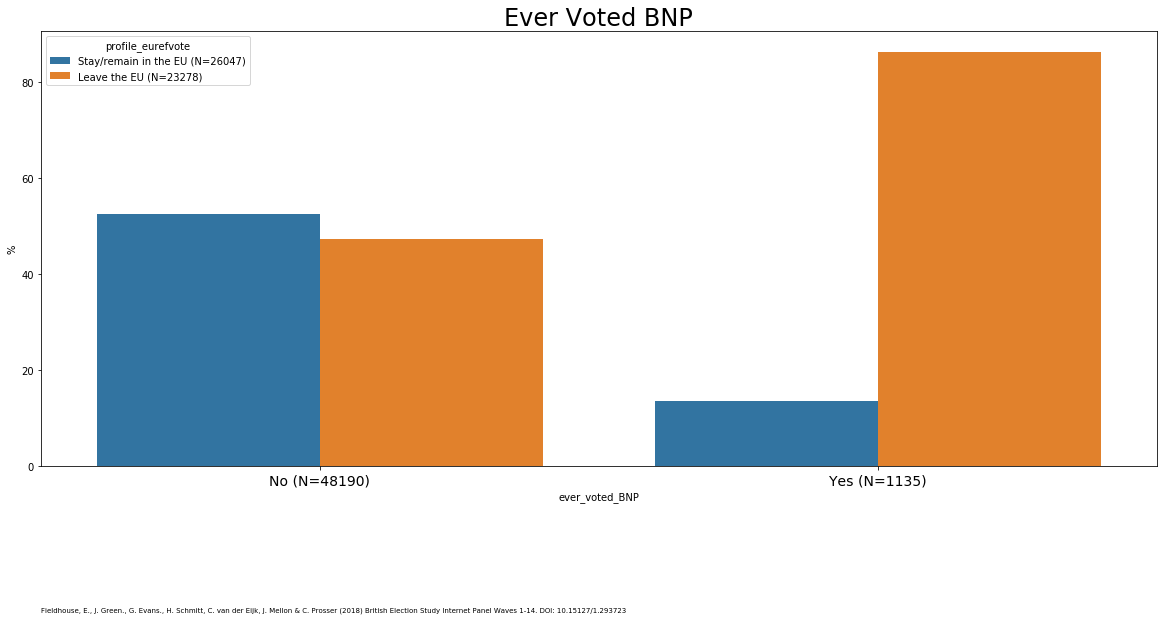

In [14]:
var2 ="ever_voted_BNP"
var1 ="profile_eurefvote"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(["Don't know"])
df1.name = var1
df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="Ever Voted BNP (in any election in the last ~10 years)")


In [23]:
BNP_curious = BNP_curious.astype('category').cat.rename_categories(["No","Yes"])
BNP_curious.name = "BNP_curious"

Warning, filename truncated because it was over 30. Filenames may no longer be unique


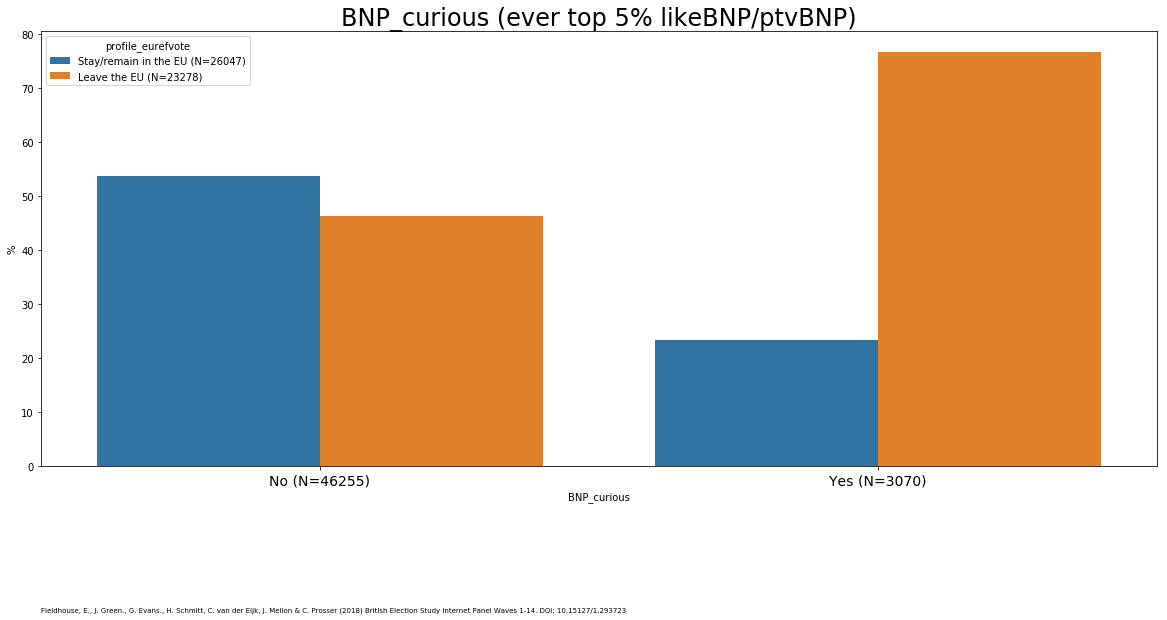

In [24]:
var2 ="BNP_curious"
var1 ="profile_eurefvote"
# amal_al_3cat.name = var2
# mask = BES_Panel["workingStatusW6_W12"]!="Retired"
# mask = BES_Panel["ageW13"] <65
# mask = BES_Panel["profile_house_tenureW13"]==BES_Panel["profile_house_tenureW13"].cat.categories[0]

df1 = BES_Panel[var1].cat.remove_categories(["Don't know"])
df1.name = var1
df2 = BNP_curious
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])
# df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories])

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 14,
              title_fontsize=24,
              title="BNP_curious (ever top 5% likeBNP/ptvBNP)")


In [ ]:
BES_reduced_with_na["ever_voted_BNP"] = ever_voted_BNP
pattern = "BNP"
name = "ever_voted_BNP"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

In [ ]:
BES_reduced_with_na["BNP_curious"] = BNP_curious
pattern = "BNP"
name = "BNP_curious"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

In [ ]:
gc.collect()

In [ ]:
#####################################
# replicate this: https://twitter.com/p_surridge/status/1104513896268869633

In [77]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

granularity=201

xlim = ( 0, granularity-1 )
ylim = ( 0, granularity-1 )

x_axis = "Economic: Left("+str(xlim[0])+") <-> Right("+str(xlim[1])+")"+"{uniform}"
y_axis = "Social: Liberalism("+str(ylim[0])+") <-> Conservatism("+str(ylim[1])+")"+"{uniform}"


uniform_PC = pan_dataset_allr_values[[x_axis, y_axis]]

x_axis = "Economic: Left("+str(xlim[0])+") <-> Right("+str(xlim[1])+")"
y_axis = "Social: Liberalism("+str(ylim[0])+") <-> Conservatism("+str(ylim[1])+")"

uniform_PC.columns = [x_axis,y_axis]
# uniform_PC

# ["Economic Left-Right","Socialism Liberalism-Conservatism"]



In [54]:
### So, what is our measure for Labour/Conservative? Most recent voting intention? Ditto euref?

partyVI_var = "generalElectionVoteW14"
eurefVI_var = "euRefVoteW14"

# partyVI = BES_Panel[partyVI_var]
# eurefVI = BES_Panel[eurefVI_var]



mask = BES_Panel[partyVI_var].notnull() & BES_Panel[eurefVI_var].notnull()

party_and_euref_VI = BES_Panel[[partyVI_var,eurefVI_var]][mask].apply(lambda x:'&'.join(map(str, x)), axis=1)
party_and_euref_VI.value_counts()



Conservative&Leave the EU                                         7144
Labour&Stay/remain in the EU                                      6159
Conservative&Stay/remain in the EU                                2427
Don't know&Leave the EU                                           2204
Don't know&Stay/remain in the EU                                  2173
Liberal Democrat&Stay/remain in the EU                            1907
Labour&Leave the EU                                               1764
United Kingdom Independence Party (UKIP)&Leave the EU              974
Scottish National Party (SNP)&Stay/remain in the EU                806
Don't know&Don't know                                              761
Green Party&Stay/remain in the EU                                  629
I would not vote&I would/will not vote                             552
I would not vote&Leave the EU                                      468
Conservative&Don't know                                            375
I woul

In [136]:
def centre_of_mass_marker(x,y, color, label):
    plt.plot(x.mean(),y.mean(),'rx')
    
def centre_of_mass_marker_free_colour(x,y, color, label):
    log_relative_sample_size = 3*(np.log10(len(x))- np.log10(df.shape[0]))
    plt.plot(x.mean(),y.mean(), color=color, marker ='x', label=label, markersize=20 + log_relative_sample_size)
    
def centre_of_mass(x,y, color, label):
    plt.annotate(str(wave_no),xy= (x.mean(),y.mean()))    
    
def plot_axes(x,y, color, label):
    plt.axhline(y=np.median( range(0,granularity) ), alpha=.2, linestyle='--',color='grey')
    plt.axvline(x=np.median( range(0,granularity) ), alpha=.2, linestyle='--',color='grey')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, alpha=.2, linestyle='--',color='grey')
    plt.plot([0, 1], [1, 0], transform=plt.gca().transAxes, alpha=.2, linestyle='--',color='grey')
    
wave_to_description = BES_file_manifest[ BES_file_manifest["Only_or_Combined"]=="Only" ].set_index("Wave No")["Friendlier_Description"]

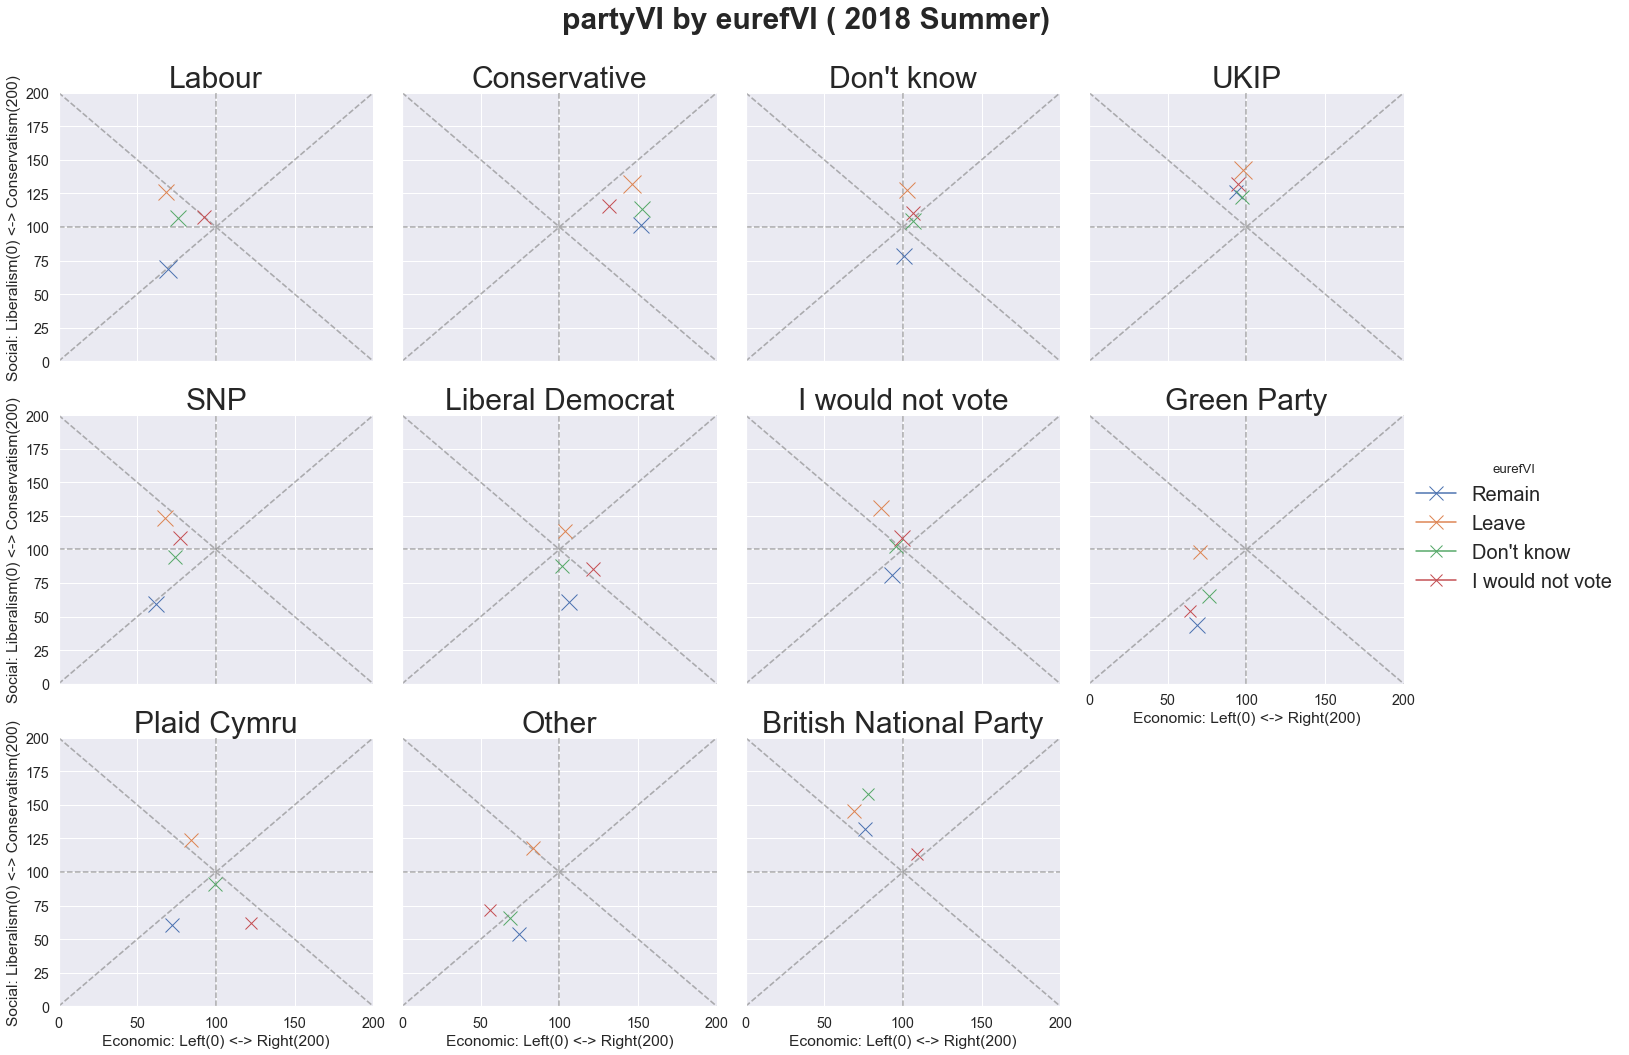

In [134]:
Treatment = "pan-dataset-values" +"split by eurefVI"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )


df = uniform_PC.copy()

size=20/4

sns.set(font_scale=1.3)

n_rows=1

title_manual = "partyVI by eurefVI"+" ( "+wave_to_description[14] +")"

# make the actual graphs
df["partyVI"] = BES_Panel[partyVI_var]
df["eurefVI"] = BES_Panel[eurefVI_var]

cats = [re.sub("\s\(\w+\)","",x) for x in df["partyVI"].cat.categories]
cats= [re.sub('Scottish National Party',"SNP",x) for x in cats]
cats= [re.sub('United Kingdom Independence Party',"UKIP",x) for x in cats]
df["partyVI"].cat.rename_categories(cats, inplace=True)


df["eurefVI"].cat.rename_categories(["Remain","Leave","I would not vote","Don't know"], inplace=True)


g = sns.FacetGrid(df, height=size, col = "partyVI", hue="eurefVI", col_wrap=4, aspect=1,
                  col_order = df["partyVI"].value_counts().index,
                  hue_order = df["eurefVI"].value_counts().index)
# if waves:
#     g.map(centre_of_mass,x_axis, y_axis)
g.map(plot_axes,x_axis,y_axis)
g.map(centre_of_mass_marker_free_colour,x_axis, y_axis).set_titles("{col_name}",size=30).add_legend(fontsize=20)
# plt.legend()

# g

# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False,
#       cut=0, levels=20, bw='scott').set_titles("" )


plt.xlim(xlim)
plt.ylim(ylim)   

plt.subplots_adjust( top = 1-(.1  ) )


if title_manual is None:
    title = col
else:
    title = title_manual

g.fig.suptitle(title, fontsize=30, fontweight='bold');

# save to file
g.savefig(output_subfolder +os.sep+ "partyVIbyeurefVIW14" , bbox_inches='tight')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

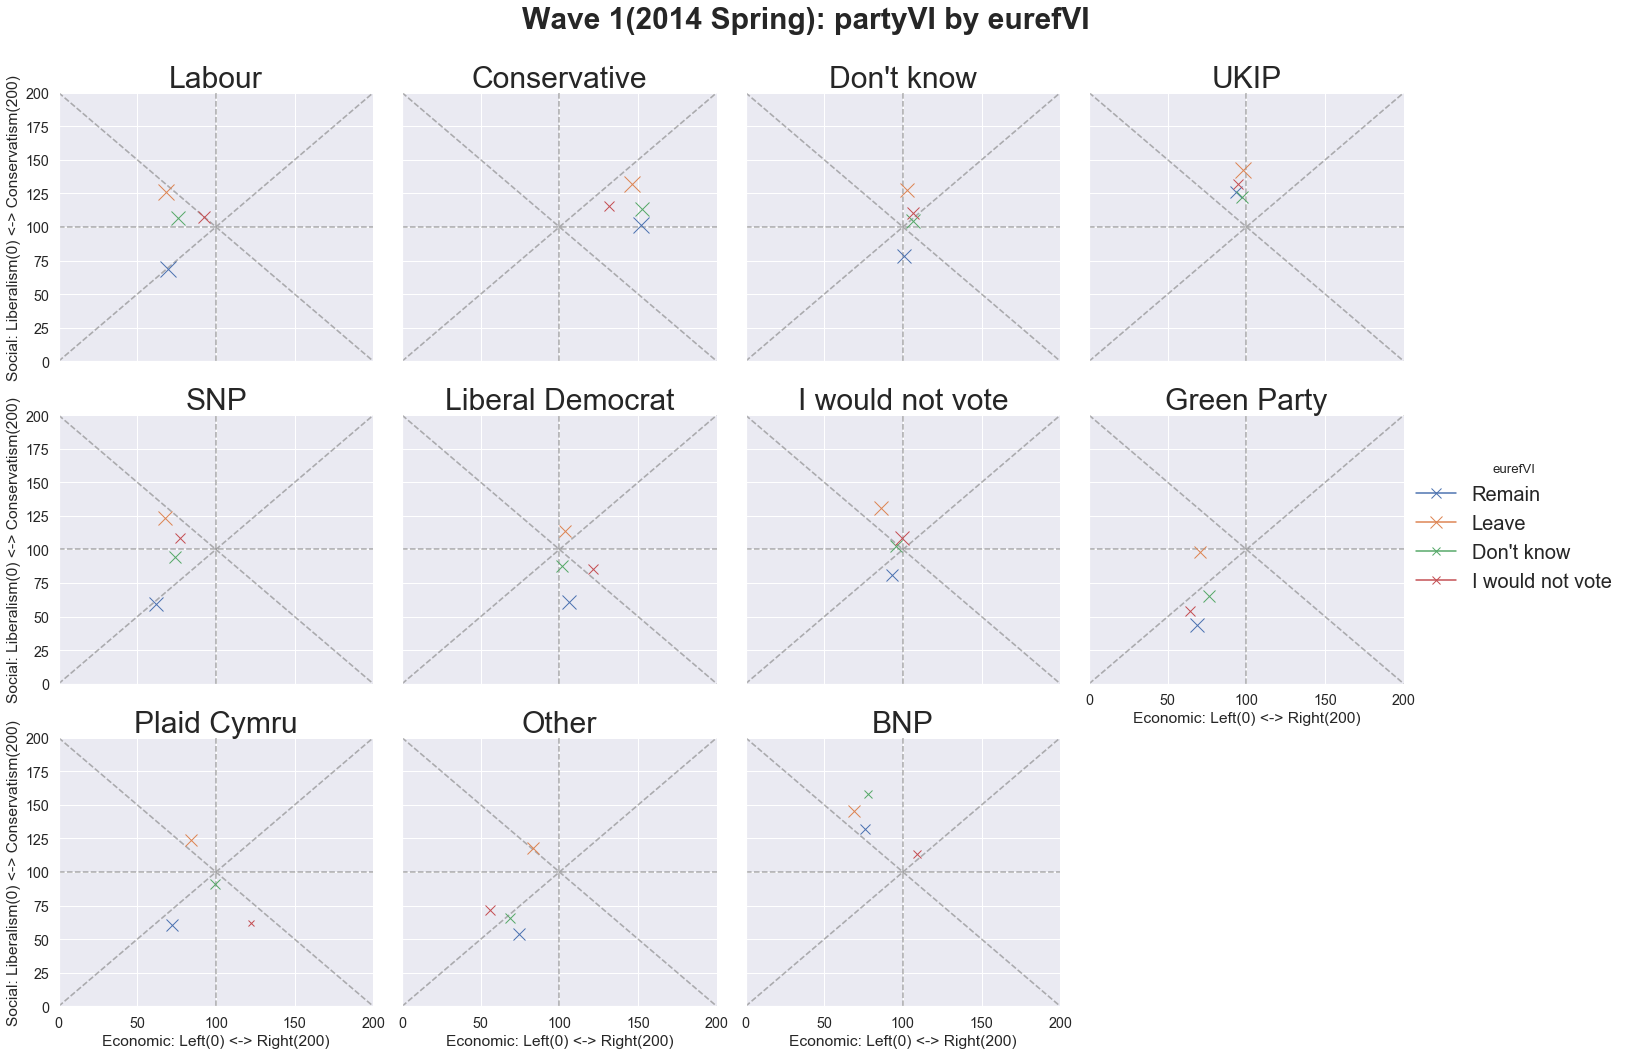

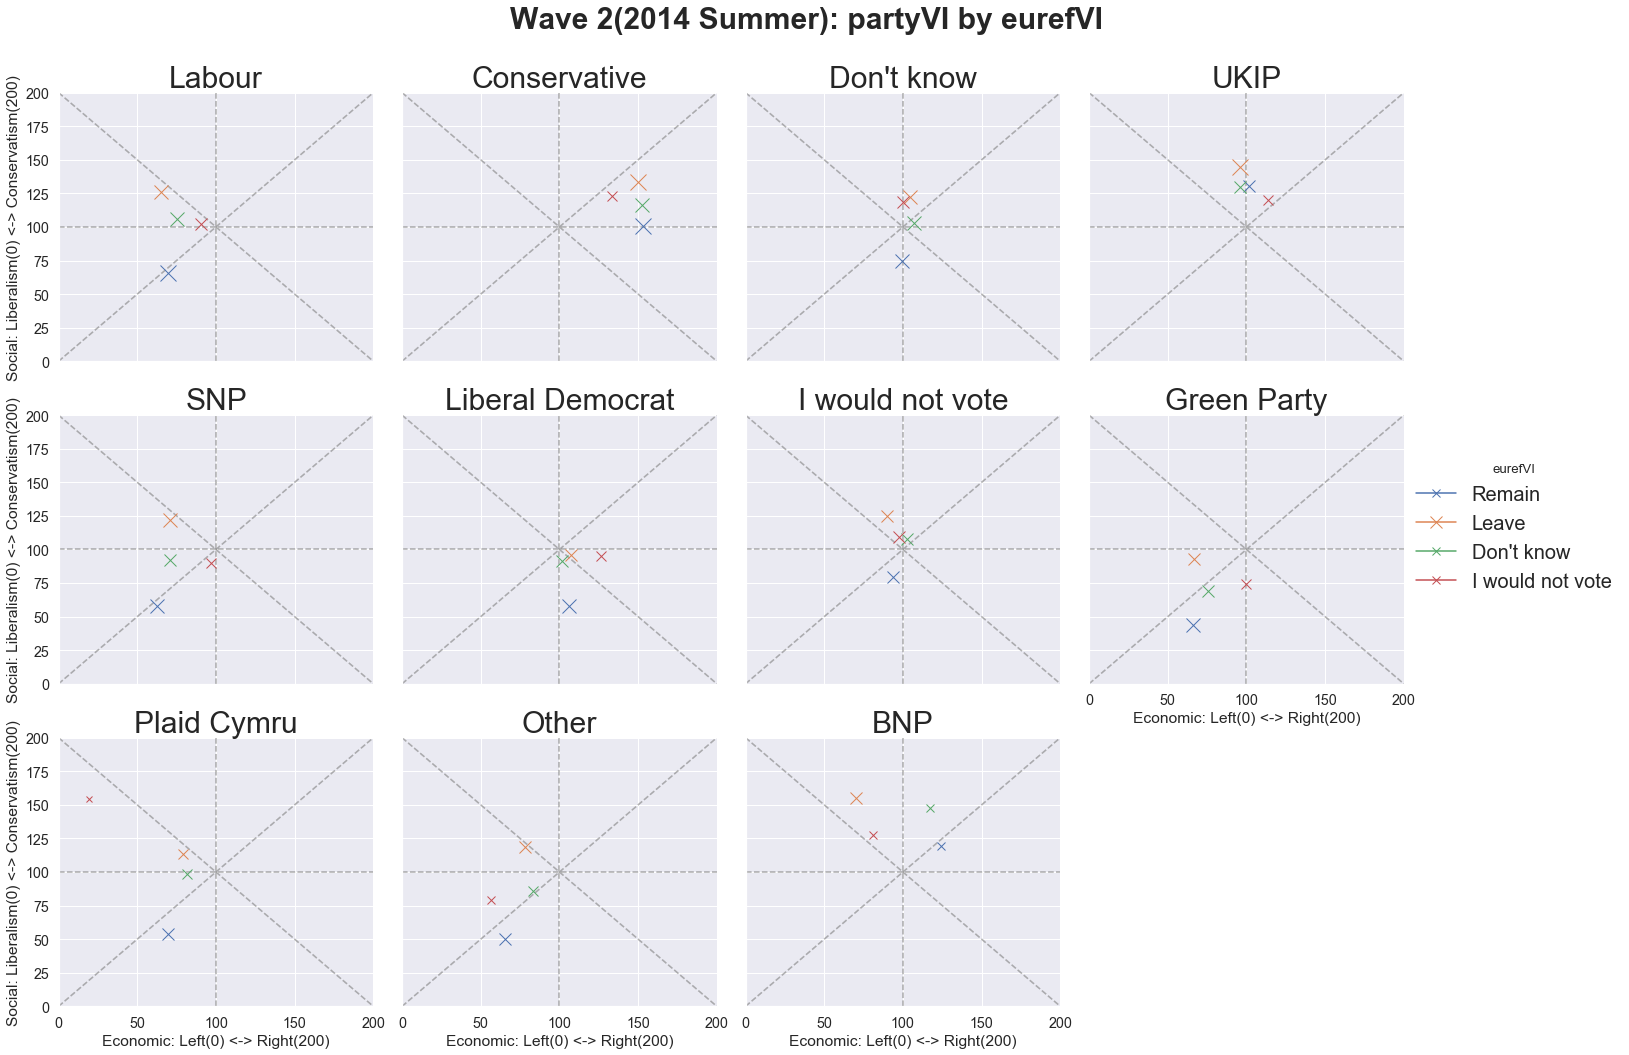

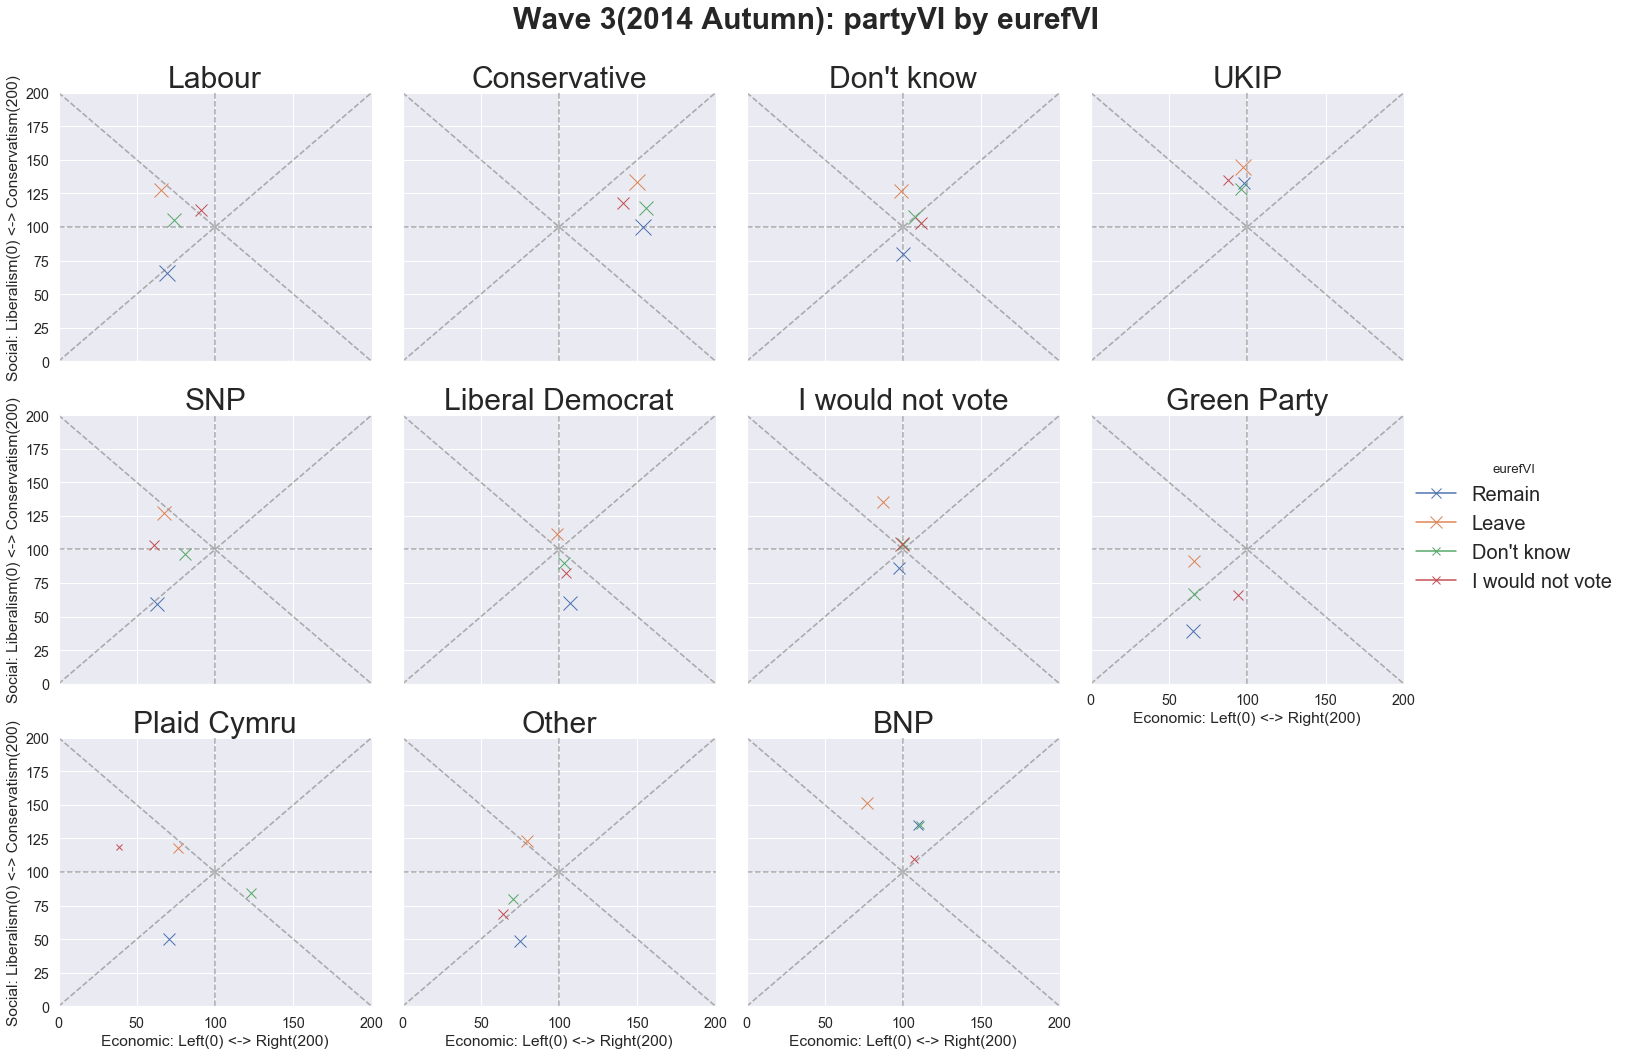

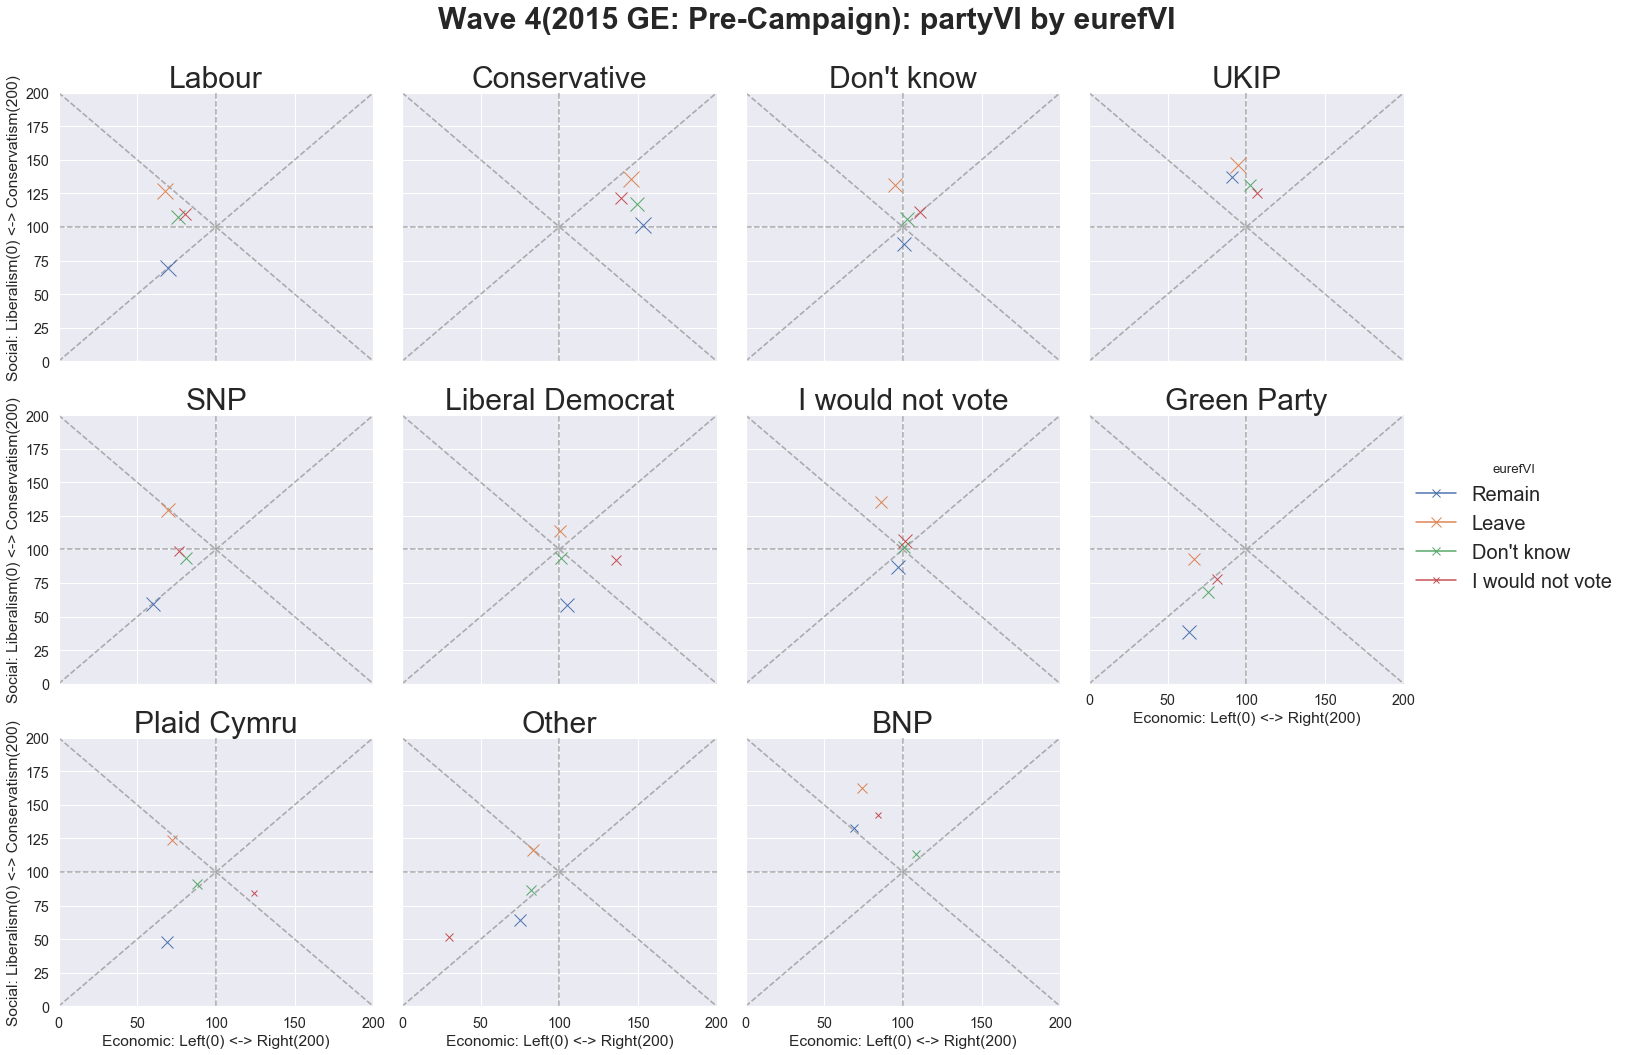

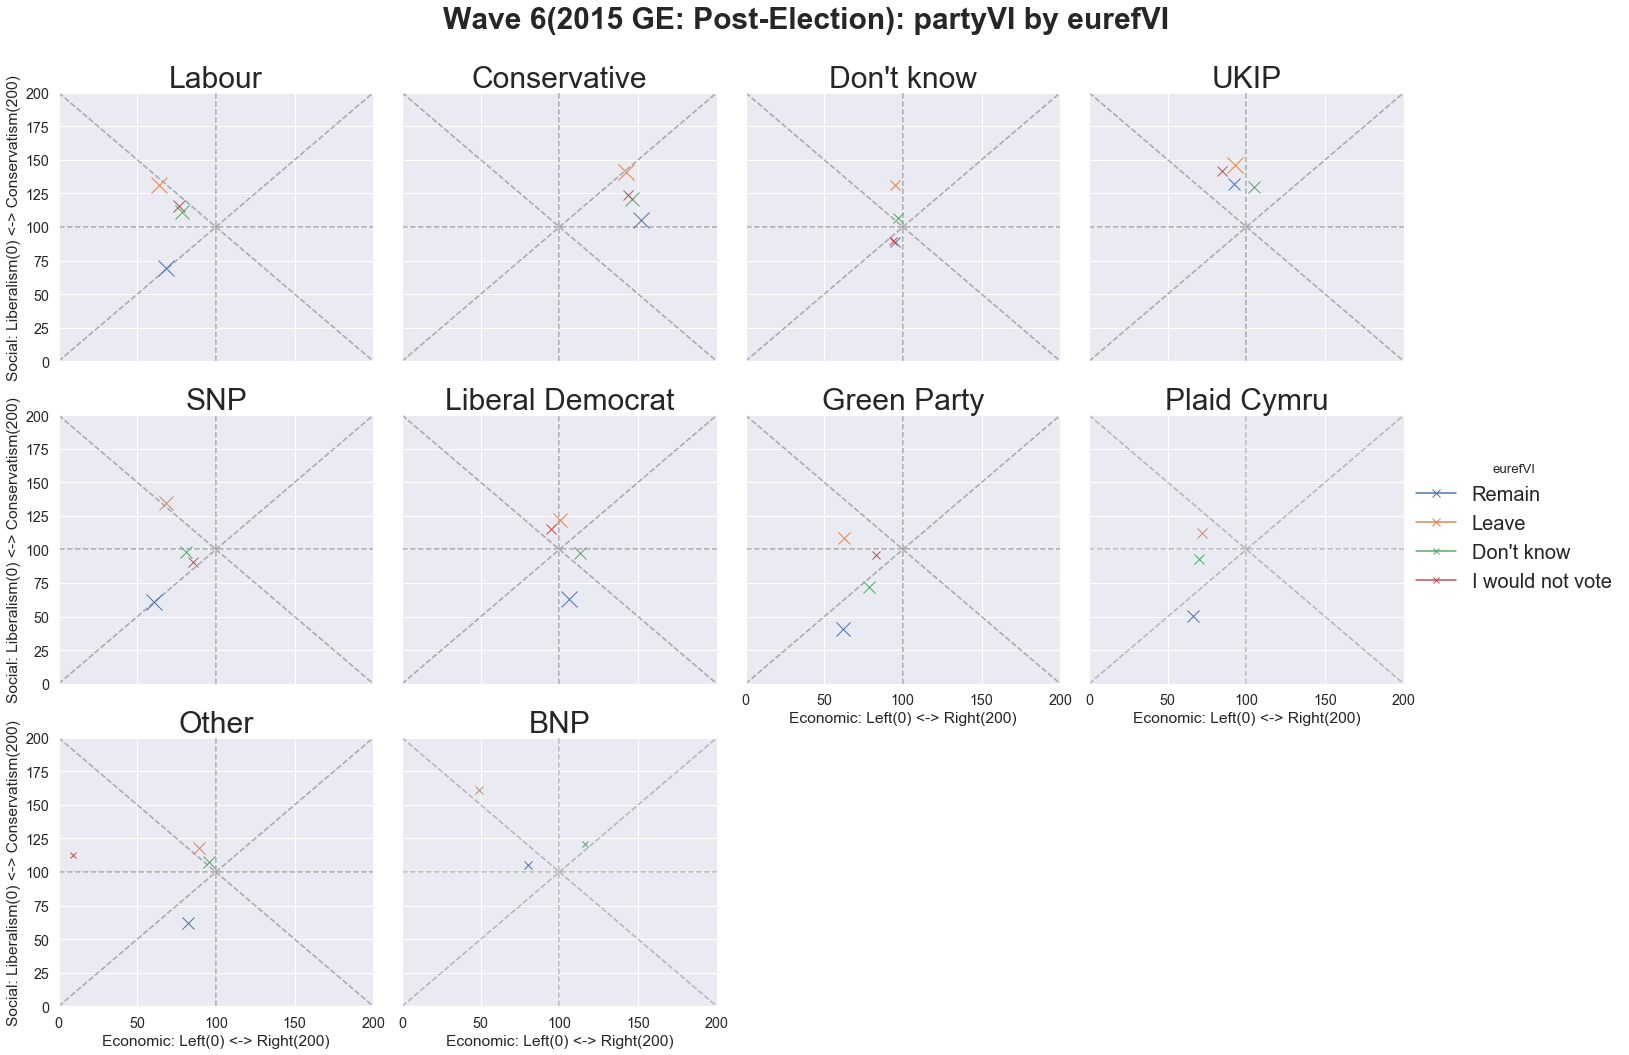

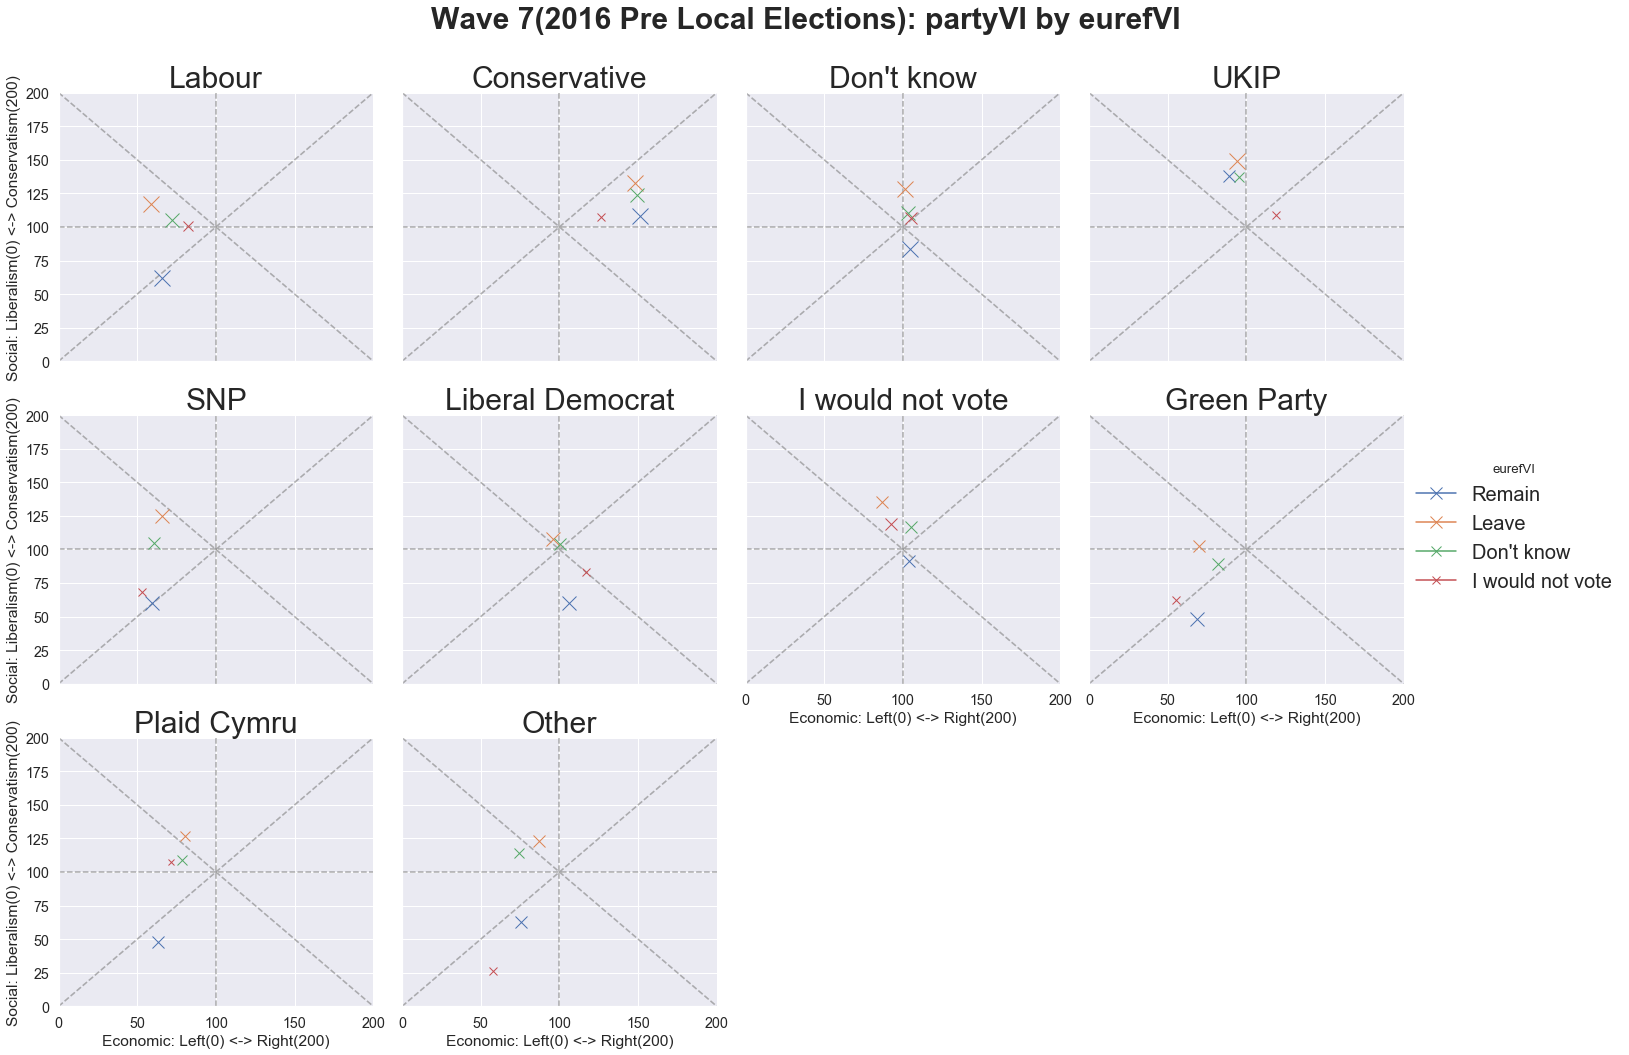

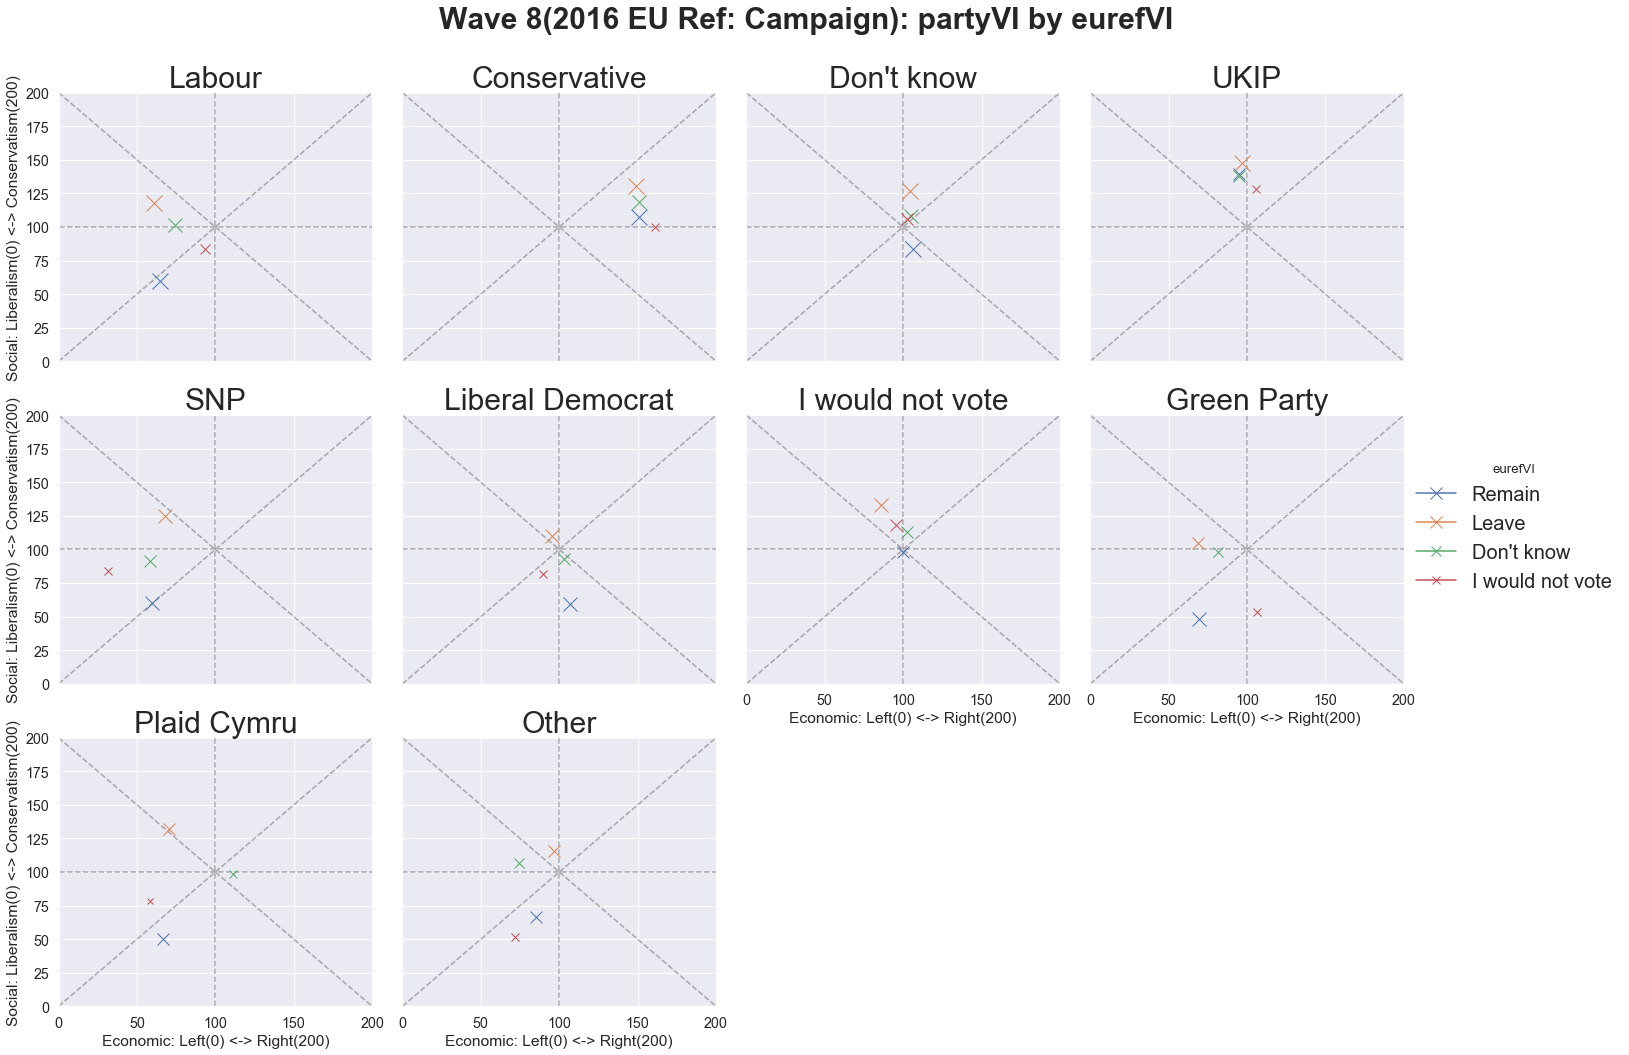

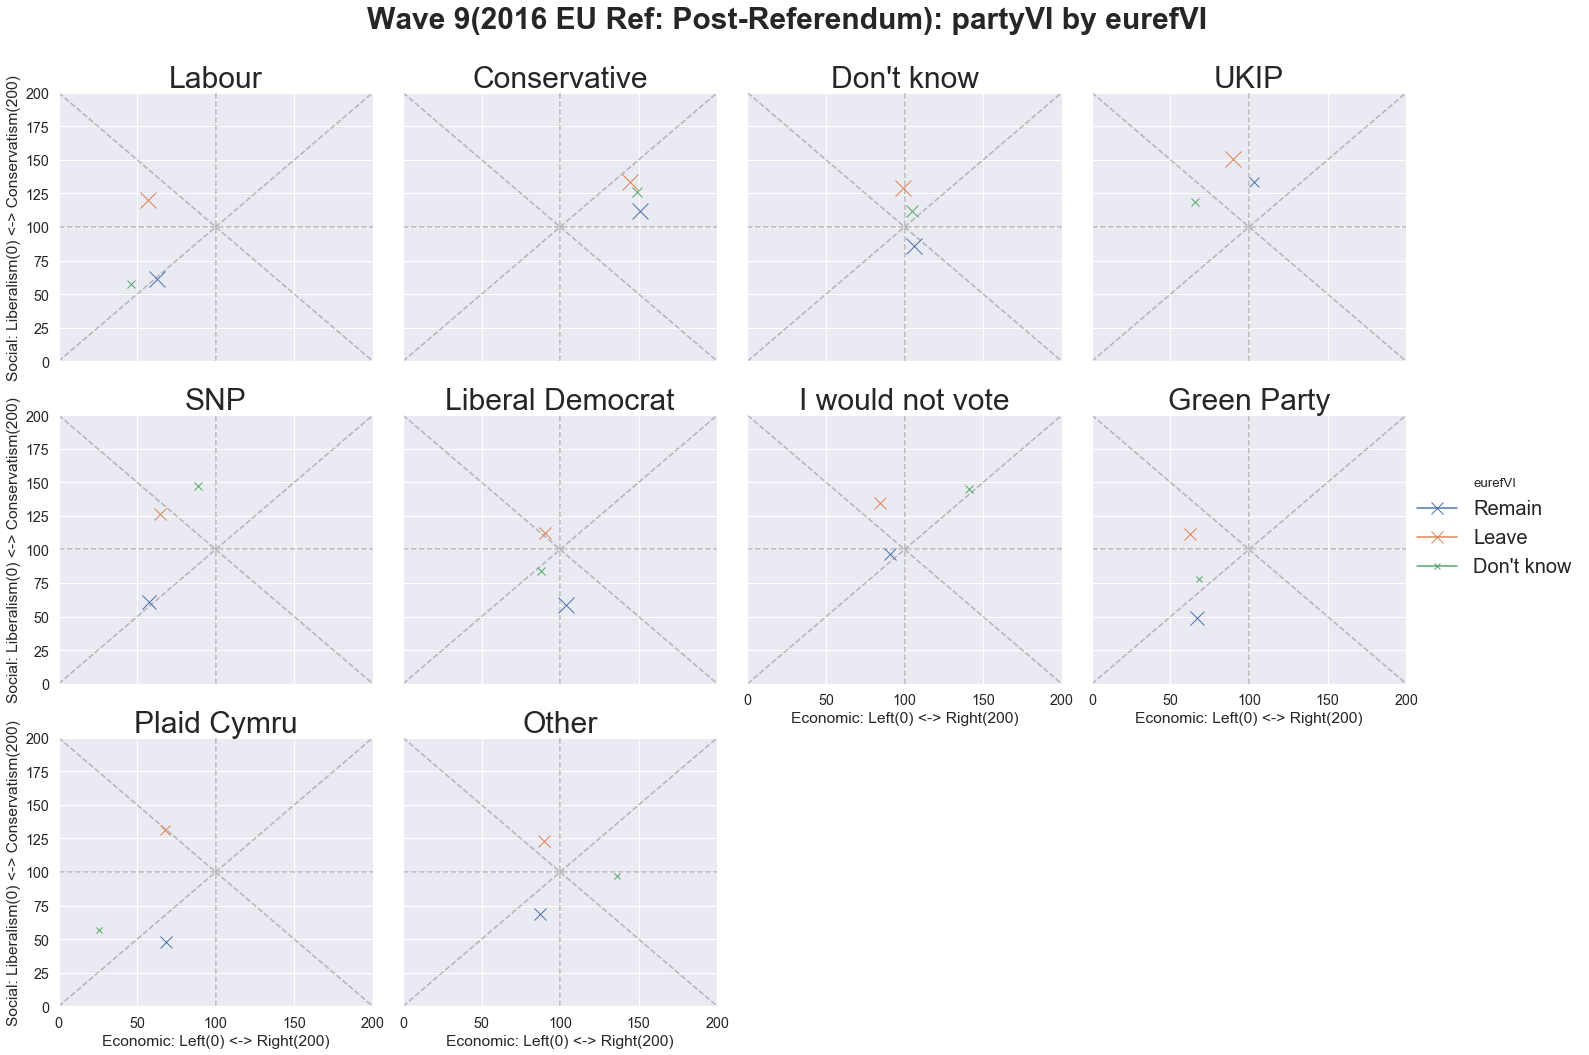

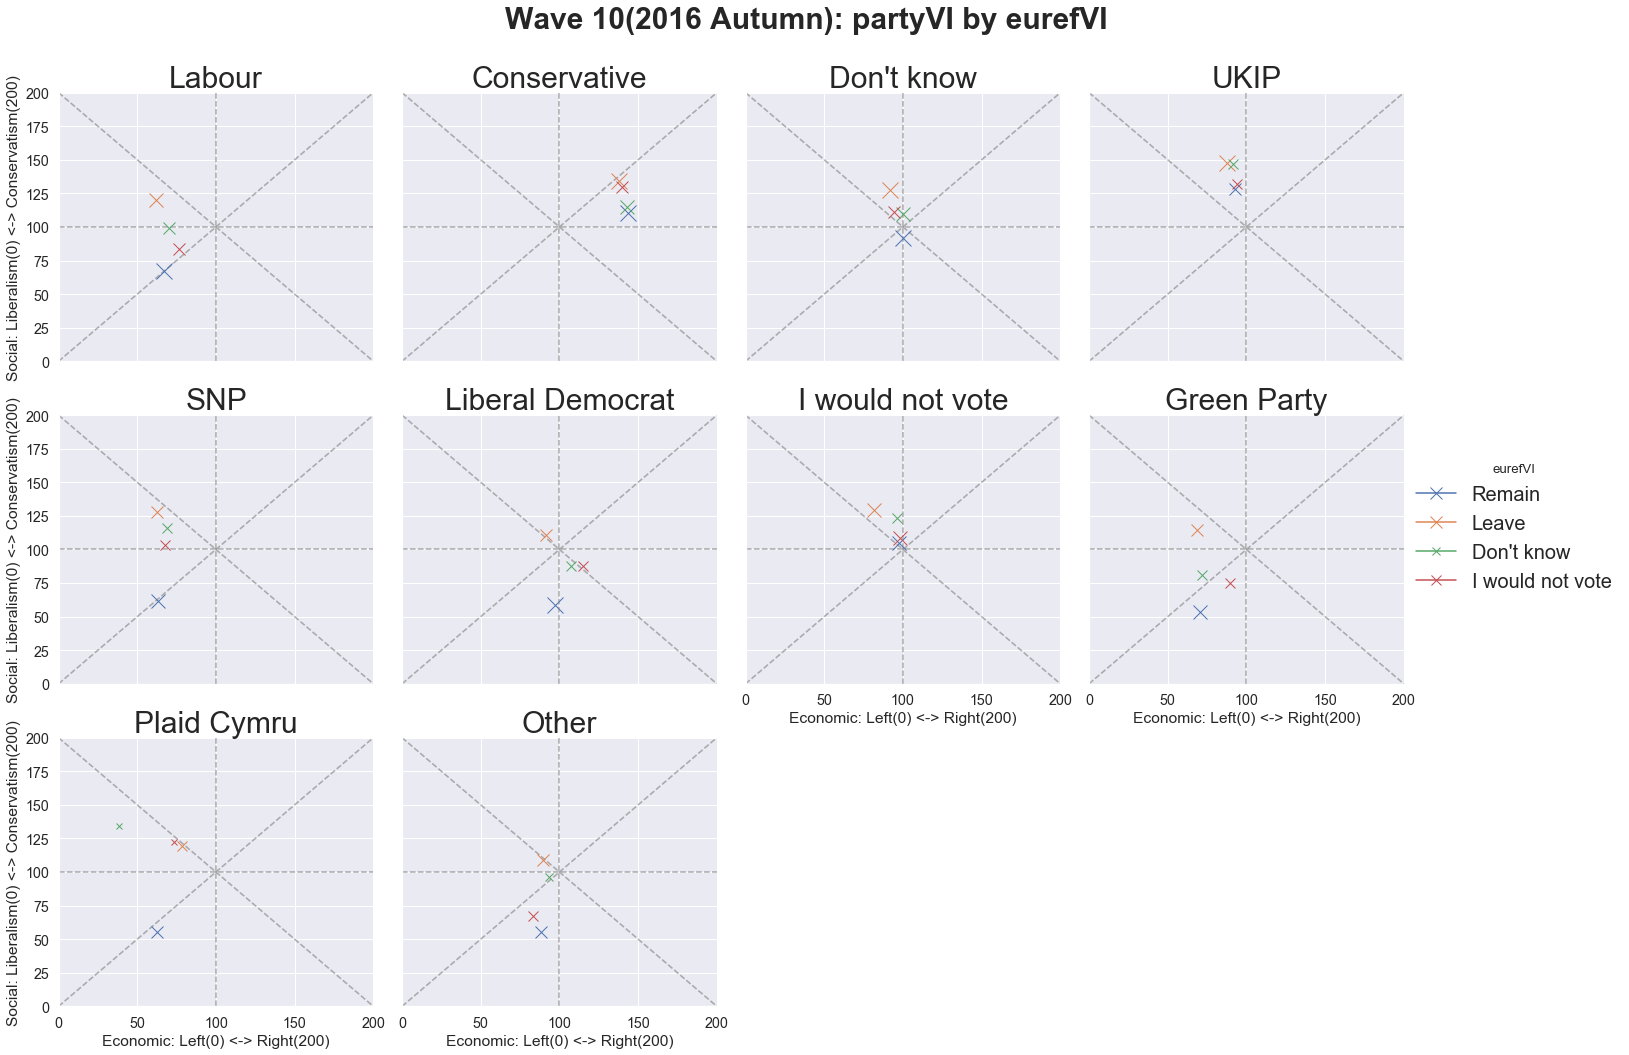

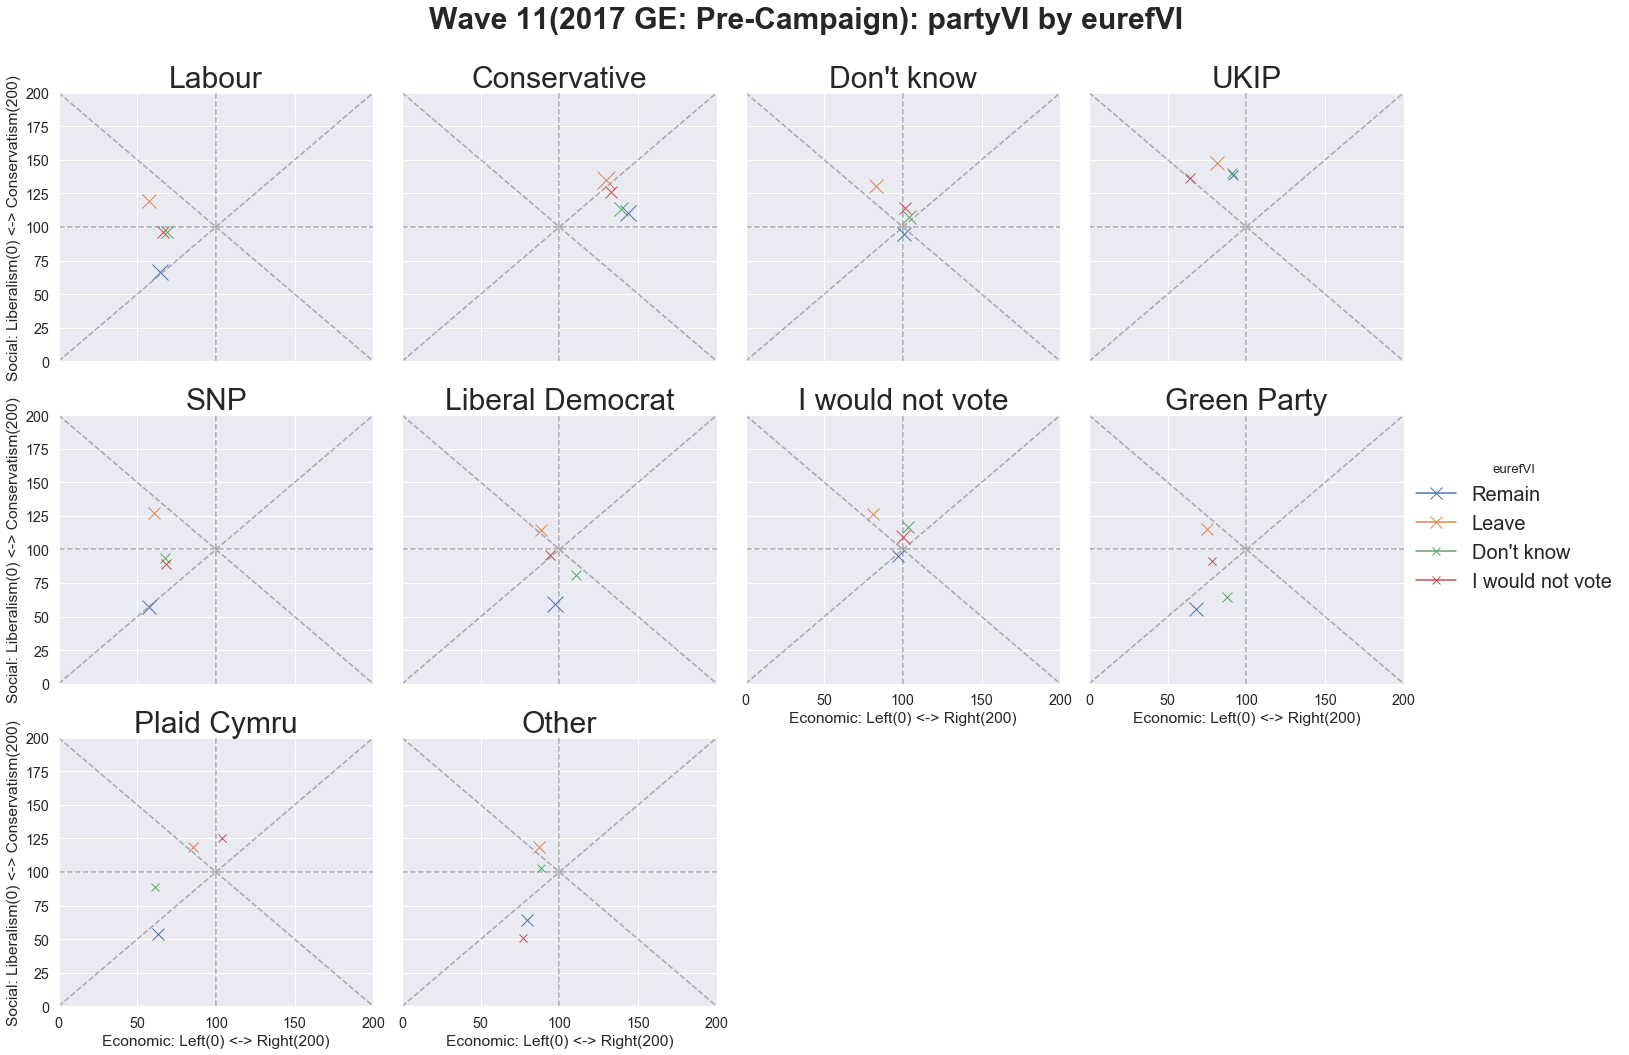

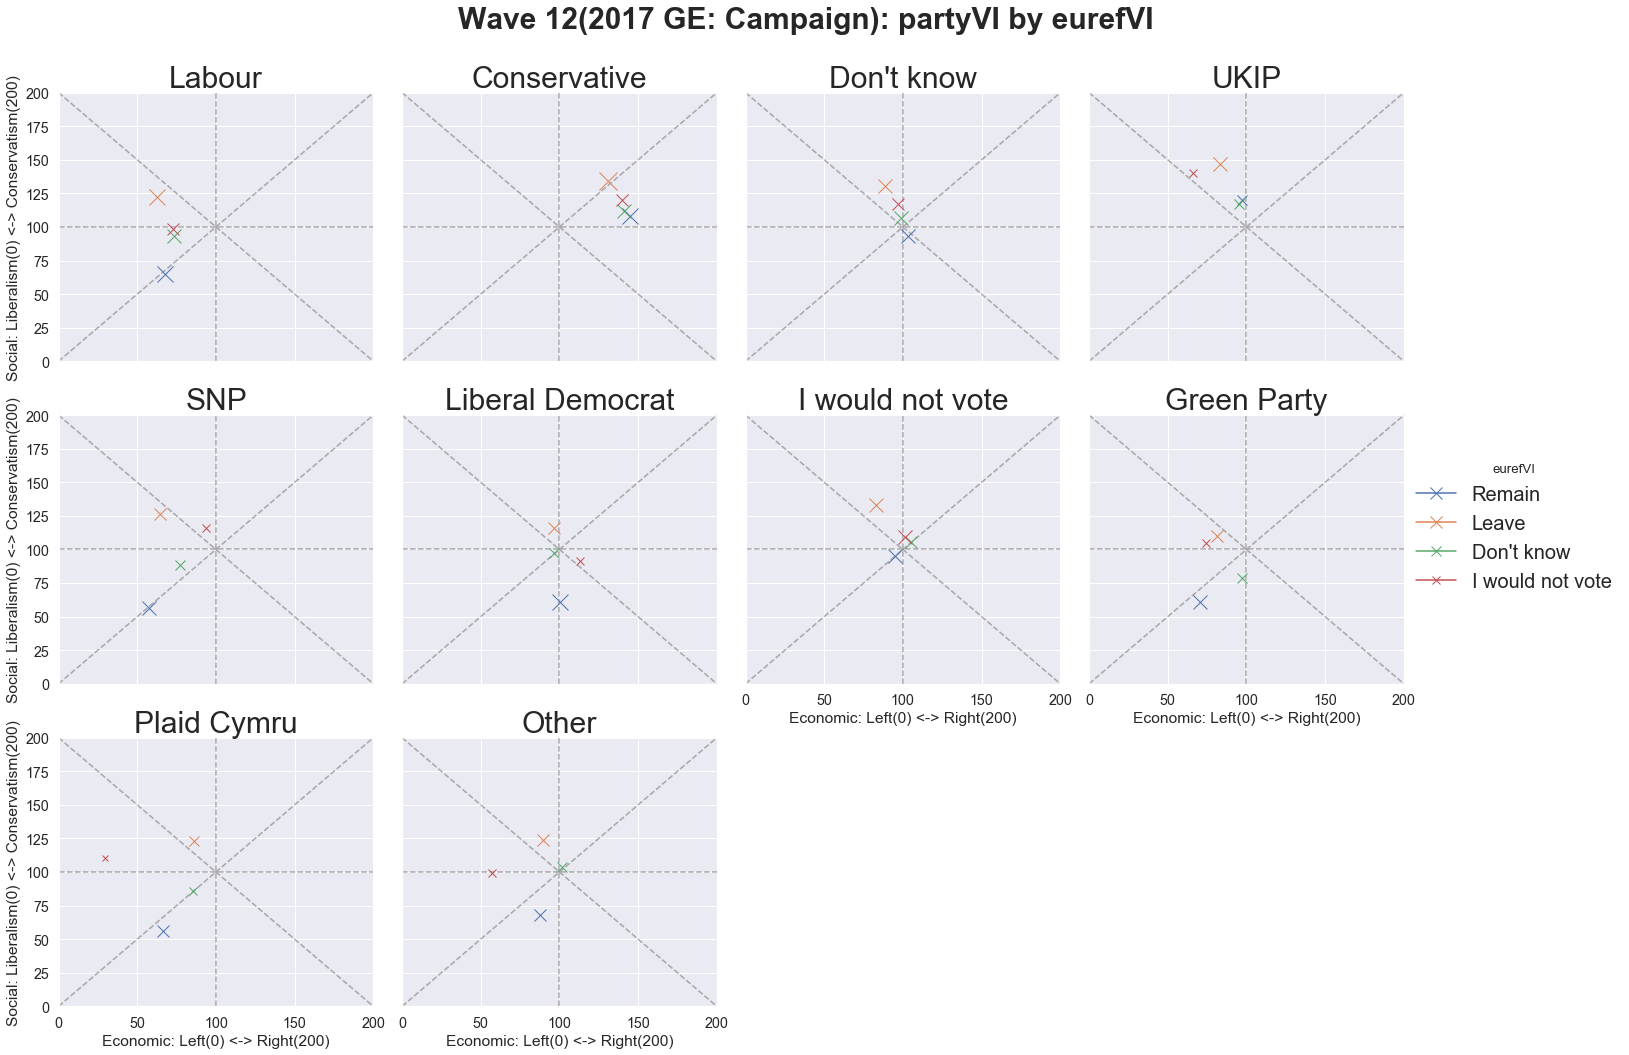

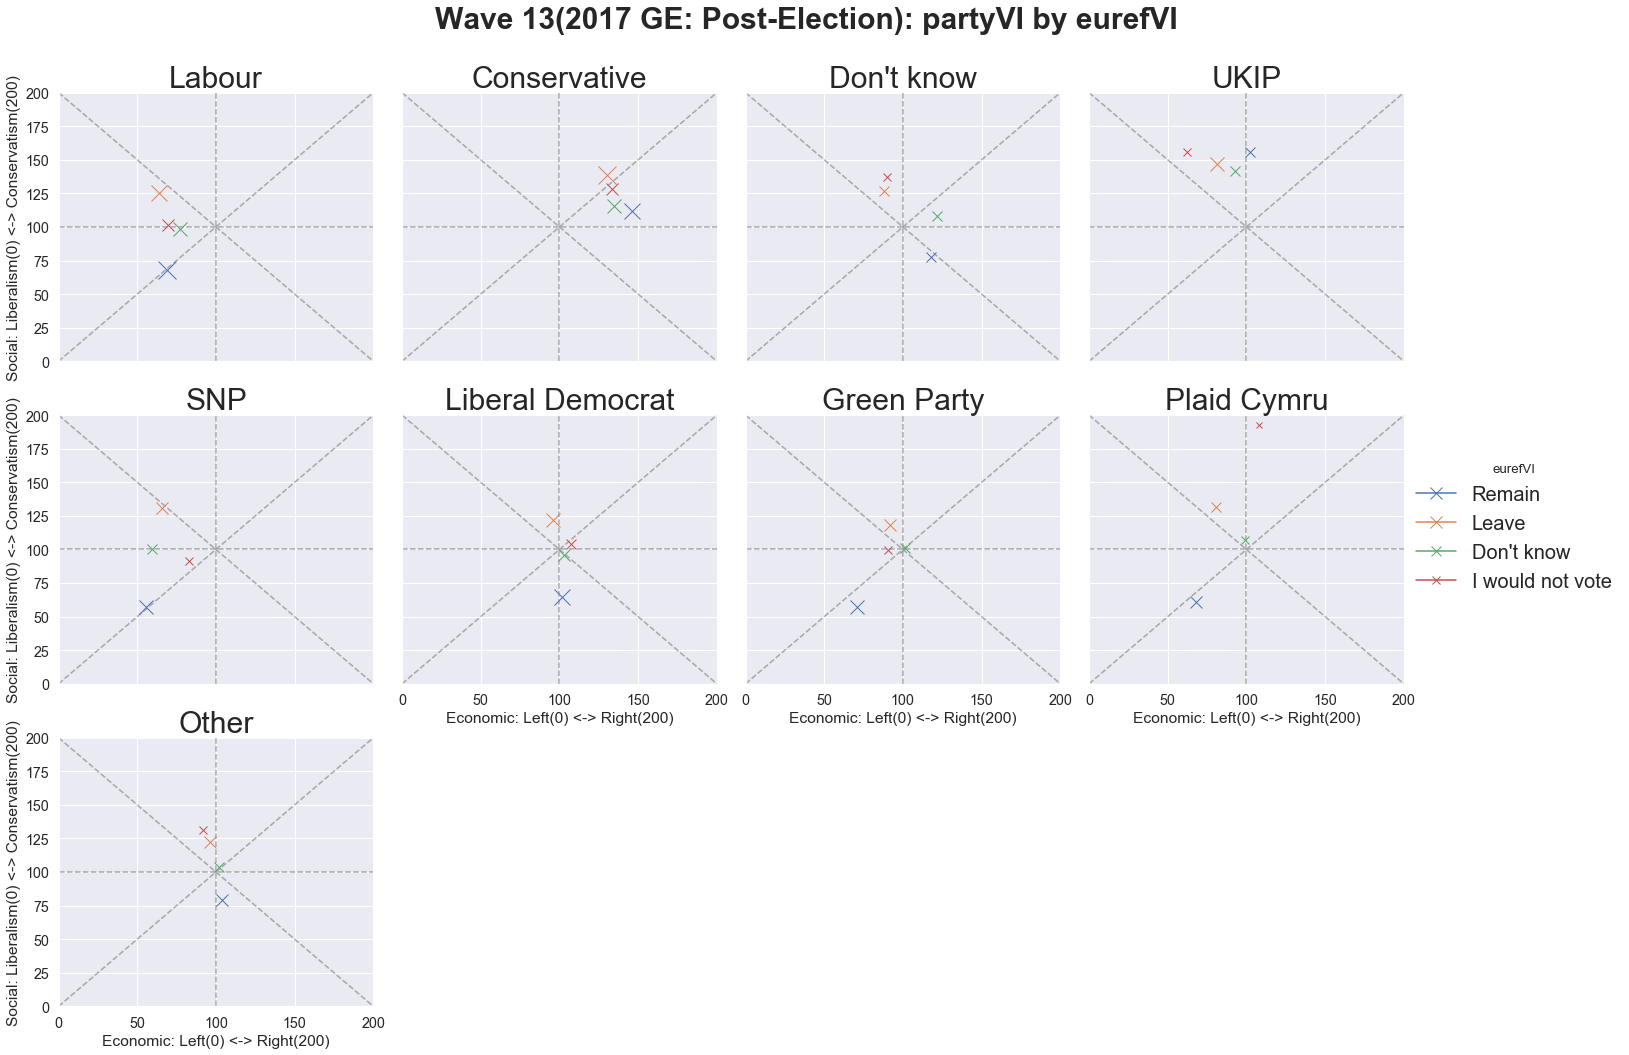

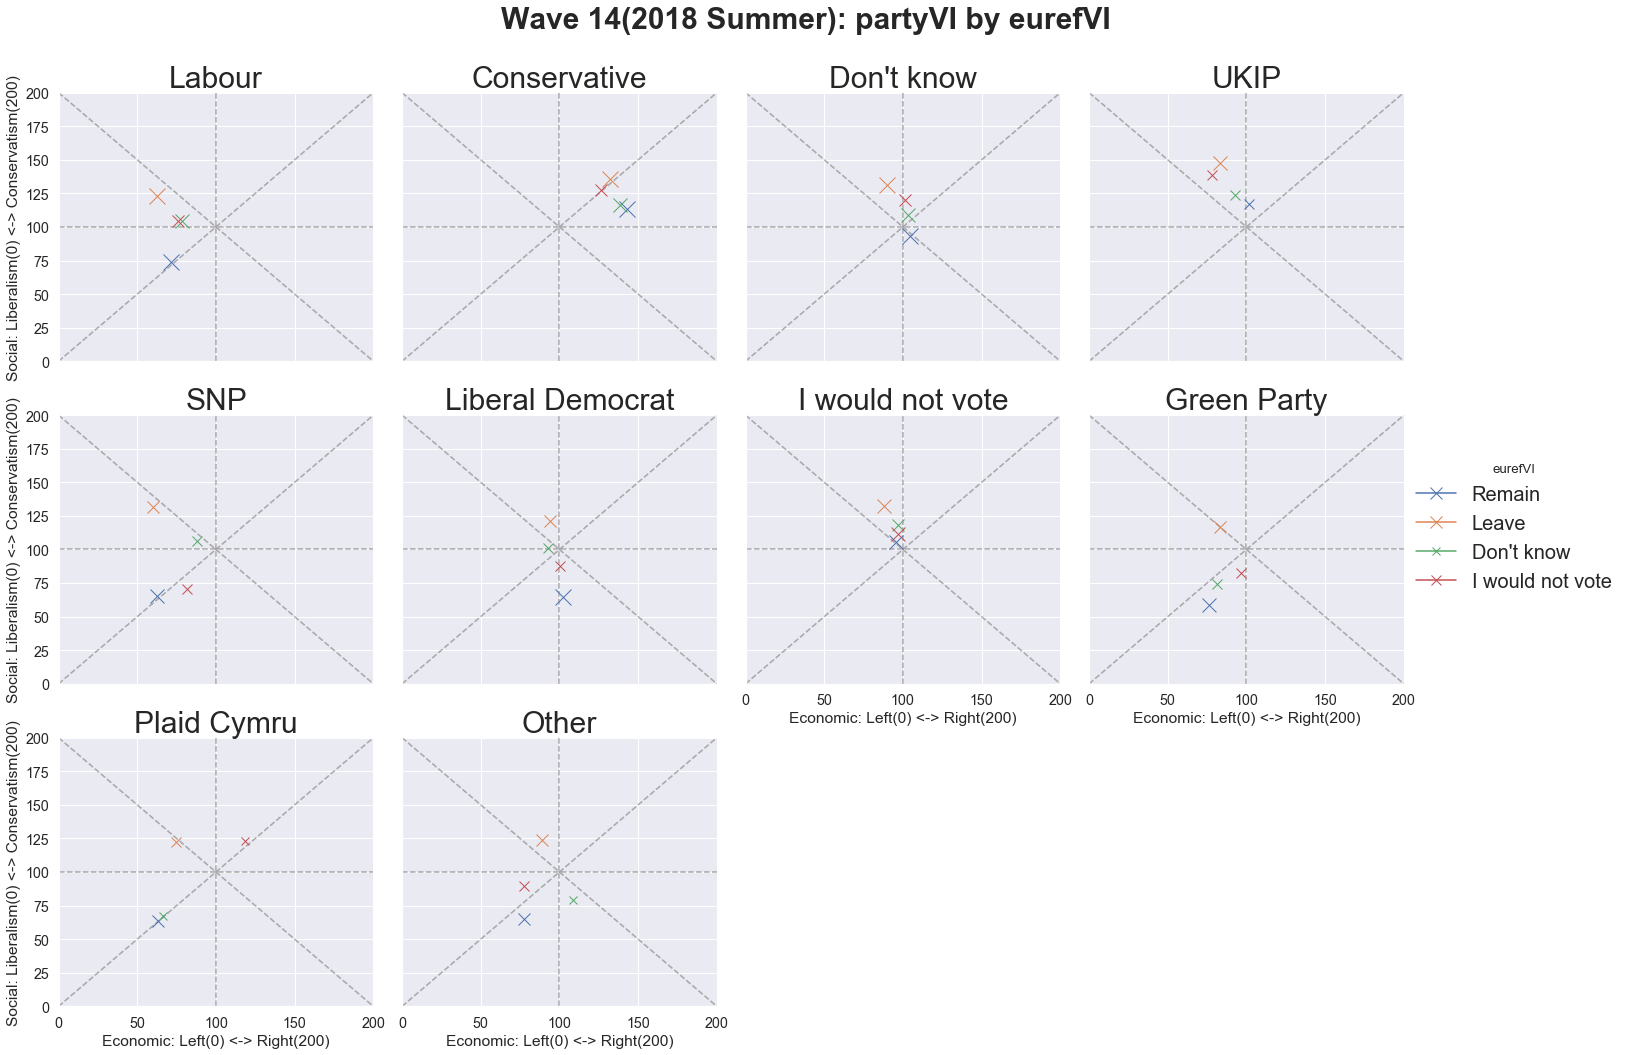

In [141]:
import imageio

max_cats = 30 # maximum number of categories
max_text_length = 70
max_cat_text_length = 30
import textwrap
wrapper = textwrap.TextWrapper(width=max_cat_text_length)


graph_type = "mean_positions/"
folder = output_subfolder + Treatment +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    
for wave_no in sorted(wave_to_description.keys()):
    if wave_no==5:
        continue
    
    df = uniform_PC.copy()
    
    partyVI_var = "generalElectionVoteW"+str(wave_no)
    eurefVI_var = "euRefVoteW"+str(wave_no)
    
    title_manual = "Wave "+str(wave_no)+"("+wave_to_description[wave_no] +"): " +"partyVI by eurefVI"

    # make the actual graphs
    df["partyVI"] = BES_Panel[partyVI_var]
    df["eurefVI"] = BES_Panel[eurefVI_var]

    cats = [re.sub("\s\(\w+\)","",x) for x in df["partyVI"].cat.categories]
    cats= [re.sub('Scottish National Party',"SNP",x) for x in cats]
    cats= [re.sub('United Kingdom Independence Party',"UKIP",x) for x in cats]
    cats= [re.sub('British National Party',"BNP",x) for x in cats]
    df["partyVI"].cat.rename_categories(cats, inplace=True)

    if wave_no==9:
        df["eurefVI"].cat.rename_categories(["Remain","Leave","Don't know"], inplace=True)    
    else:
        df["eurefVI"].cat.rename_categories(["Remain","Leave","I would not vote","Don't know"], inplace=True)
        
    if wave_no==1:
        base_col_order = df["partyVI"].value_counts().index
        base_hue_order = df["eurefVI"].value_counts().index
    col_order = intersection(base_col_order,df["partyVI"].cat.categories)
    hue_order = intersection(base_hue_order,df["eurefVI"].cat.categories)
        
        
        
    g = sns.FacetGrid(df, height=size, col = "partyVI", hue="eurefVI", col_wrap=4, aspect=1,
                      col_order = col_order,
                      hue_order = hue_order)

    g.map(plot_axes,x_axis,y_axis)
    g.map(centre_of_mass_marker_free_colour,x_axis, y_axis).set_titles("{col_name}",size=30).add_legend(fontsize=20)


    plt.xlim(xlim)
    plt.ylim(ylim)   

    plt.subplots_adjust( top = 1-(.1  ) )


    if title_manual is None:
        title = col
    else:
        title = title_manual

    g.fig.suptitle(title, fontsize=30, fontweight='bold');

    # save to file
    g.savefig(output_subfolder +os.sep+ "partyVIbyeurefVIW"+str(wave_no) , bbox_inches='tight')  
    
    

In [142]:
#     base = "C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_output\pan-dataset-valuessplit by eurefVI
wave_list = [1,2,3,4,6,7,8,9,10,11,12,13,14]
base_var = "partyVIbyeurefVI"

#     base_var = re.sub("W\d+$","",var_list[0])
sorted_wavelist = sorted(wave_list)
filenames = [output_subfolder+base_var+"W"+str(x)+".png" for x in sorted_wavelist]
print("building gif with: ", filenames)
# make gif if more than one file!
if len(filenames)>1:

    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(output_subfolder+base_var+'.gif', images,'GIF',
                    duration=[2.0 if x==np.min( sorted_wavelist ) else 0.6 for x in sorted_wavelist])

building gif with:  ['../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW1.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW2.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW3.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW4.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW6.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW7.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW8.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW9.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW10.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW11.png', '../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\partyVIbyeurefVIW12.png', '../BES_analysis_output/pan-dataset-value

In [127]:
# output_subfolder

'../BES_analysis_output/pan-dataset-valuessplit by eurefVI\\'

In [ ]:
#################################################################
# https://twitter.com/epkaufm/status/1105031662138810369
# Age by al/lr_values, big 5



In [232]:
#Improved age values!
pan_dataset_ages = pd.read_csv(    BES_small_data_files + "pan_dataset_ages"+".csv")
pan_dataset_ages.columns
# pan_dataset_ages["Age_at_W1"]

Index(['id', 'Age_at_W1', 'Age_at_W1_rounded', 'Age_at_W7', 'Age_at_W8',
       'Age_at_W9', 'Age_at_W11', 'Age_at_W12', 'Age_at_W13', 'Age_at_W14',
       'standardAgeGroup_at_W1', 'equalisedAgeGroup_at_W1',
       'equalLengthAgeGroup_at_W1'],
      dtype='object')

In [225]:
pan_dataset_ages = pd.read_msgpack(    BES_small_data_files + "pan_dataset_ages"+".msgpack")

In [178]:
Treatment = "pan-dataset-values" +"(better)age_by_education"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


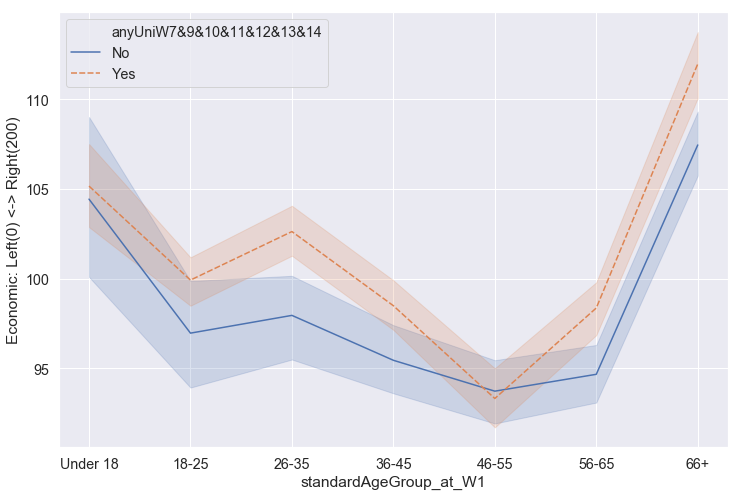

In [229]:
# uniform_PC, Age
plt.figure(figsize=(12,8))
sns.lineplot(pan_dataset_ages["standardAgeGroup_at_W1"],
             uniform_PC["Economic: Left(0) <-> Right(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated);
plt.savefig(output_subfolder +os.sep+ "lr_by_age_education_standardgps" , bbox_inches='tight') 

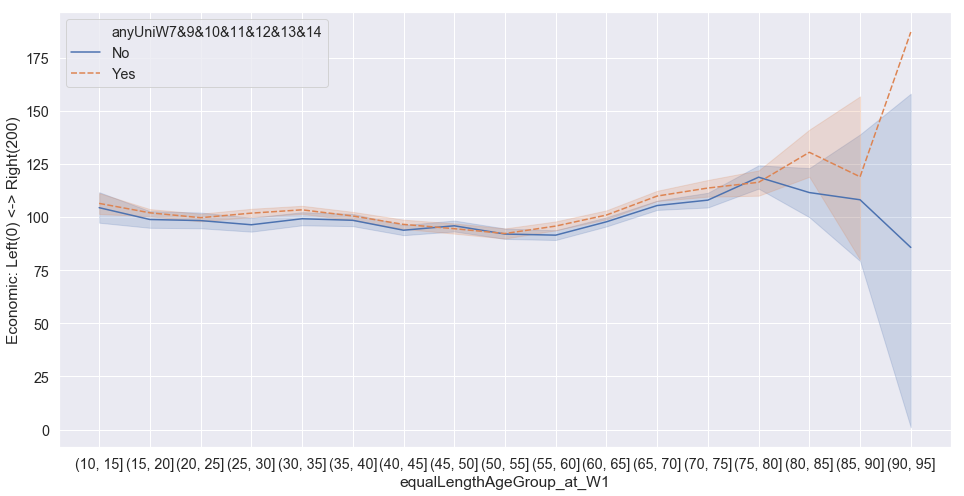

In [234]:
# uniform_PC, Age
plt.figure(figsize=(16,8))
sns.lineplot(pan_dataset_ages["equalLengthAgeGroup_at_W1"],
             uniform_PC["Economic: Left(0) <-> Right(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated);
plt.savefig(output_subfolder +os.sep+ "lr_by_age_education_equalLengthgps" , bbox_inches='tight') 

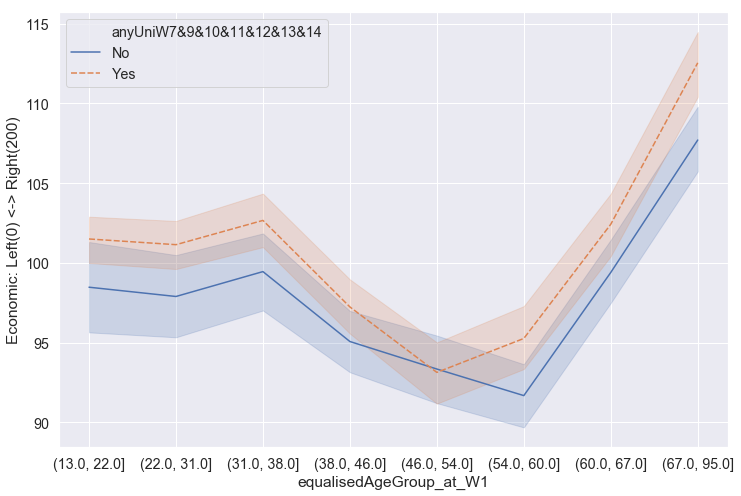

In [235]:
# uniform_PC, Age
plt.figure(figsize=(12,8))
sns.lineplot(pan_dataset_ages["equalisedAgeGroup_at_W1"],
             uniform_PC["Economic: Left(0) <-> Right(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated);
plt.savefig(output_subfolder +os.sep+ "lr_by_age_education_equalisedgps" , bbox_inches='tight') 

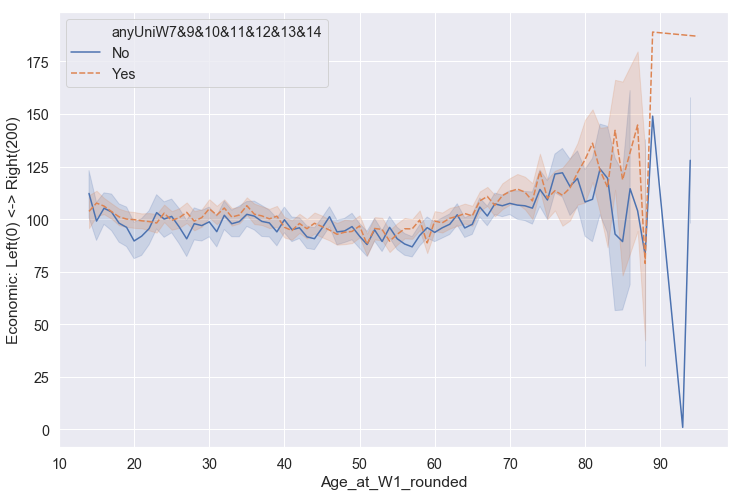

In [231]:
# uniform_PC, Age
plt.figure(figsize=(12,8))
sns.lineplot(pan_dataset_ages["Age_at_W1_rounded"],
             uniform_PC["Economic: Left(0) <-> Right(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated);
plt.savefig(output_subfolder +os.sep+ "lr_by_age_education_age_rounded" , bbox_inches='tight') 

In [ ]:
# uniform_PC, Age
plt.figure(figsize=(12,8))
sns.lineplot(pan_dataset_ages["Age_at_W1"],
             uniform_PC["Social: Liberalism(0) <-> Conservatism(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated );
plt.savefig(output_subfolder +os.sep+ "al_by_age_education" , bbox_inches='tight') 

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


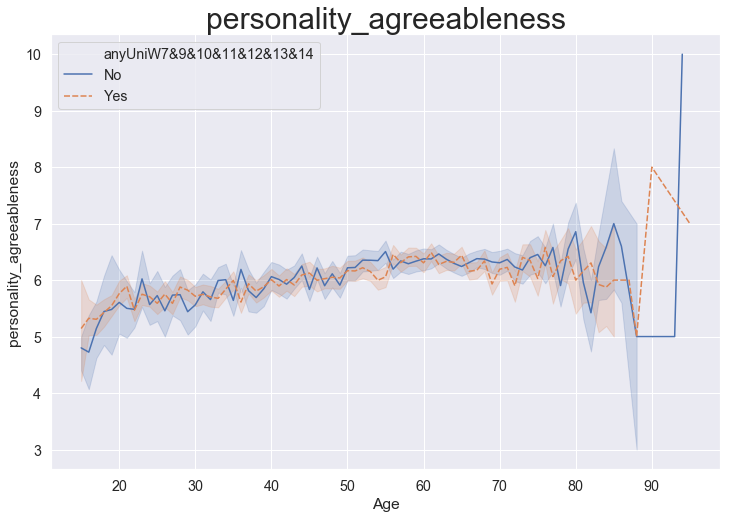

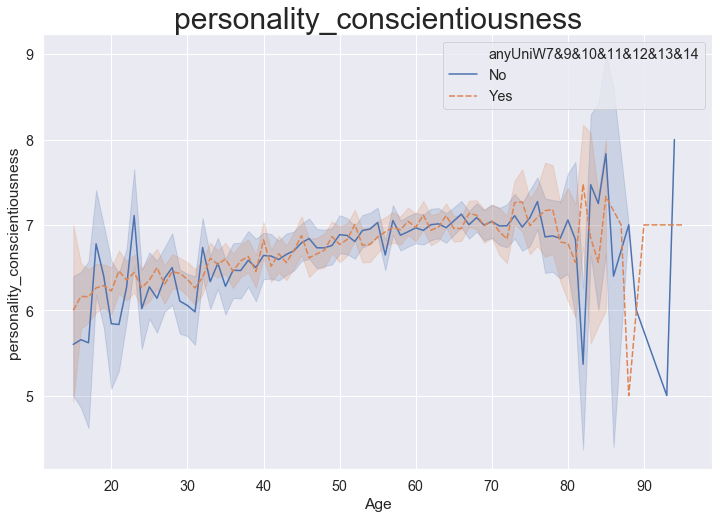

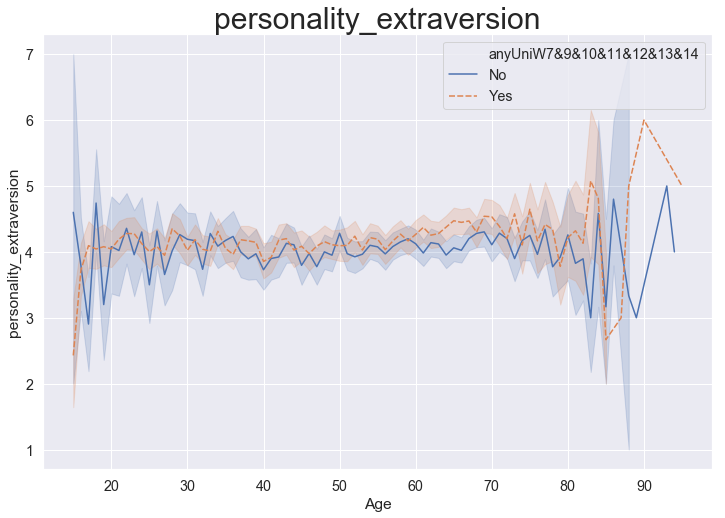

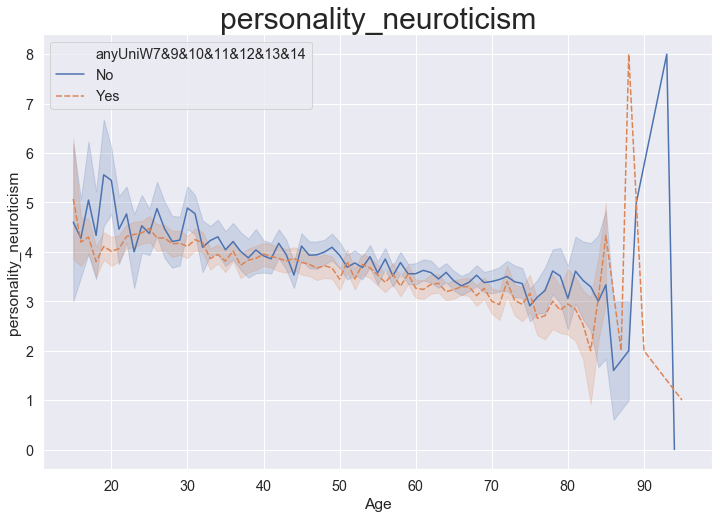

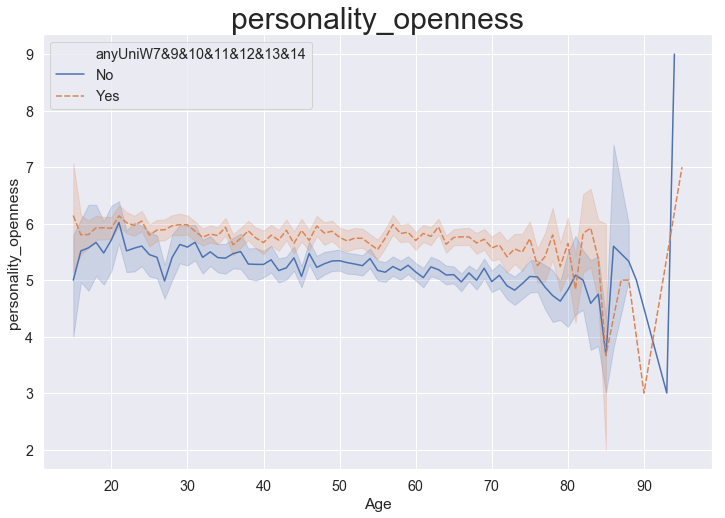

In [204]:
for big5 in search(BES_reduced_with_na,"personality").index:

    plt.figure(figsize=(12,8))

    sns.lineplot(BES_reduced_with_na["Age"],
                 BES_reduced_with_na[big5],
                 style=anyUni_amalgamated, hue=anyUni_amalgamated );
    plt.savefig(output_subfolder +os.sep+ big5+"_by_age_education" , bbox_inches='tight')
    plt.title(big5, fontsize=30)

In [181]:
search(BES_reduced_with_na,"personality")

personality_agreeableness        51244
personality_conscientiousness    51244
personality_extraversion         51245
personality_neuroticism          51242
personality_openness             51242
dtype: int64

In [202]:
anyUni_amalgamated = amalgamate_waves(BES_reduced_with_na, "anyUni")
anyUni_amalgamated.value_counts()

Amalgamating variables: 
{7: 'anyUniW7__Yes, I graduated from higher education', 9: 'anyUniW9__Yes, I graduated from higher education', 10: 'anyUniW10__Yes, I graduated from higher education', 11: 'anyUniW11__Yes, I graduated from higher education', 12: 'anyUniW12__Yes, I graduated from higher education', 13: 'anyUniW13__Yes, I graduated from higher education', 14: 'anyUniW14__Yes, I graduated from higher education'}


3.0    27247
0.0    22109
2.0     4848
1.0     4150
Name: anyUniW7&9&10&11&12&13&14, dtype: int64

In [203]:
anyUni_amalgamated[anyUni_amalgamated==0.0] = "No"
anyUni_amalgamated[anyUni_amalgamated==1.0] = "Yes"
anyUni_amalgamated[anyUni_amalgamated==2.0] = "Yes"
anyUni_amalgamated[anyUni_amalgamated==3.0] = "Yes"

anyUni_amalgamated = anyUni_amalgamated.astype('category')

'personality_agreeableness'

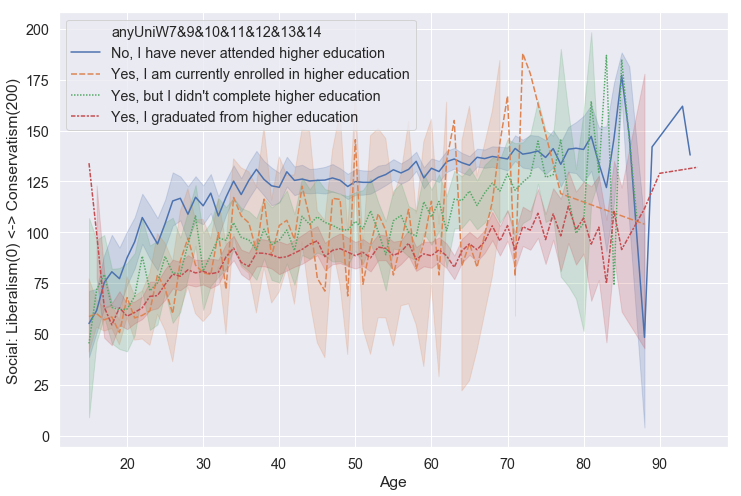

In [201]:
# uniform_PC, Age
anyUni_amalgamated = anyUni_amalgamated.astype('category').cat.rename_categories(cat_dictionary["anyUniW7"])

plt.figure(figsize=(12,8))
sns.lineplot(BES_reduced_with_na["Age"],
             uniform_PC["Social: Liberalism(0) <-> Conservatism(200)"],
             style=anyUni_amalgamated, hue=anyUni_amalgamated );
plt.savefig(output_subfolder +os.sep+ "al_by_age_education_subtypes" , bbox_inches='tight') 